In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from sklearn import tree
from IPython.display import Image
import pydotplus as pydot 
warnings.filterwarnings("ignore")
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.features.importances import FeatureImportances
from sklearn.ensemble import RandomForestClassifier
from numpy import set_printoptions
from sklearn.ensemble import RandomForestClassifier
set_printoptions(precision=3)
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.features.importances import FeatureImportances
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef

In [2]:
Data = pd.read_excel("Data_Gen.xlsx",sheet_name="jecinta").dropna(how = "any")
Data = Data.dropna(how = 'any')

In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2676 entries, 0 to 2723
Data columns (total 17 columns):
Cluster                       2676 non-null object
Site Name                     2676 non-null object
EFFECTIVE_DATE_OF_VISIT       2676 non-null datetime64[ns]
PREVIOUS_DATE_OF_VISIT        2676 non-null datetime64[ns]
Months                        2676 non-null object
NUMBER_OF_DAYS                2676 non-null int64
GENERATOR_1_CAPACITY_(KVA)    2676 non-null float64
CURRENT HOUR METER GE1        2676 non-null int64
PREVIOUS HOUR METER G1        2676 non-null int64
PREVIOUS_FUEL_QTE             2676 non-null float64
QTE_FUEL_FOUND                2676 non-null float64
QTE_FUEL_ADDED                2676 non-null float64
TOTALE_QTE_LEFT               2676 non-null float64
CONSUMPTION_HIS               2676 non-null float64
RUNNING_TIME                  2676 non-null float64
CONSUMPTION_RATE              2676 non-null float64
POWER TYPE                    2676 non-null object
dtype

In [4]:
Data.columns

Index(['Cluster', 'Site Name', 'EFFECTIVE_DATE_OF_VISIT',
       'PREVIOUS_DATE_OF_VISIT', 'Months', 'NUMBER_OF_DAYS',
       'GENERATOR_1_CAPACITY_(KVA)', 'CURRENT HOUR METER GE1',
       'PREVIOUS HOUR METER G1', 'PREVIOUS_FUEL_QTE', 'QTE_FUEL_FOUND',
       'QTE_FUEL_ADDED', 'TOTALE_QTE_LEFT', 'CONSUMPTION_HIS', 'RUNNING_TIME',
       'CONSUMPTION_RATE', 'POWER TYPE'],
      dtype='object')

In [5]:
Data['DailyConsumption'] = Data['CONSUMPTION_HIS']/(Data['NUMBER_OF_DAYS'])
Data.loc[~np.isfinite(Data['DailyConsumption']), 'DailyConsumption'] = 0
Data['QTE_Consumed_btn_visit'] = Data['PREVIOUS_FUEL_QTE'] - Data['QTE_FUEL_FOUND']
set_printoptions(precision=3)
Data['QTE_Consumed_btn_visit_Per_Day'] = Data['QTE_Consumed_btn_visit']/(Data['CONSUMPTION_HIS'])
Data.loc[~np.isfinite(Data['QTE_Consumed_btn_visit_Per_Day']), 'QTE_Consumed_btn_visit_Per_Day']= 0
Data['Running_time_per_day'] = Data["RUNNING_TIME"]/Data["NUMBER_OF_DAYS"]             
Data.loc[~np.isfinite(Data['Running_time_per_day']), 'Running_time_per_day'] = 0
set_printoptions(precision=3)
Data['Maximum_consumption_perDay'] = Data[['CONSUMPTION_RATE']]*24
set_printoptions(precision=3)

## Data VISUALIZATION 

Generator consumption between the month of September 2017 and March 2018. The month of September indicates the lowest fuel consumed as the data set received begins from the 20th of the month of September. December indicate the highest consumption in that period of six months and a drastic drop is experienced from the month of December to January.  

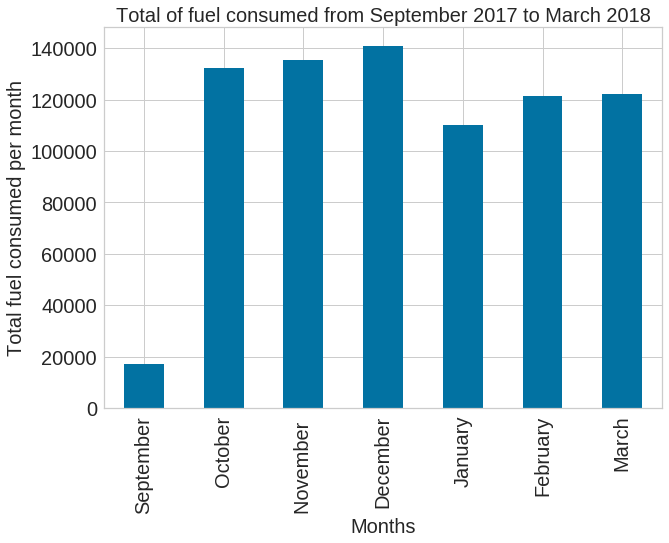

In [6]:
ax = Data.groupby('Months',sort = False)['CONSUMPTION_HIS'].sum().plot(kind= 'bar', figsize=(10,7))
#Sep['CONSUMPTION_HIS'].sum()
plt.title('Total of fuel consumed from September 2017 to March 2018',fontsize=20)
ax.set_ylabel("Total fuel consumed per month", fontsize=20);
plt.xlabel("Months",fontsize=20)
plt.yticks(fontsize=20, rotation=None)
plt.xticks(fontsize=20, rotation=90)
plt.show()

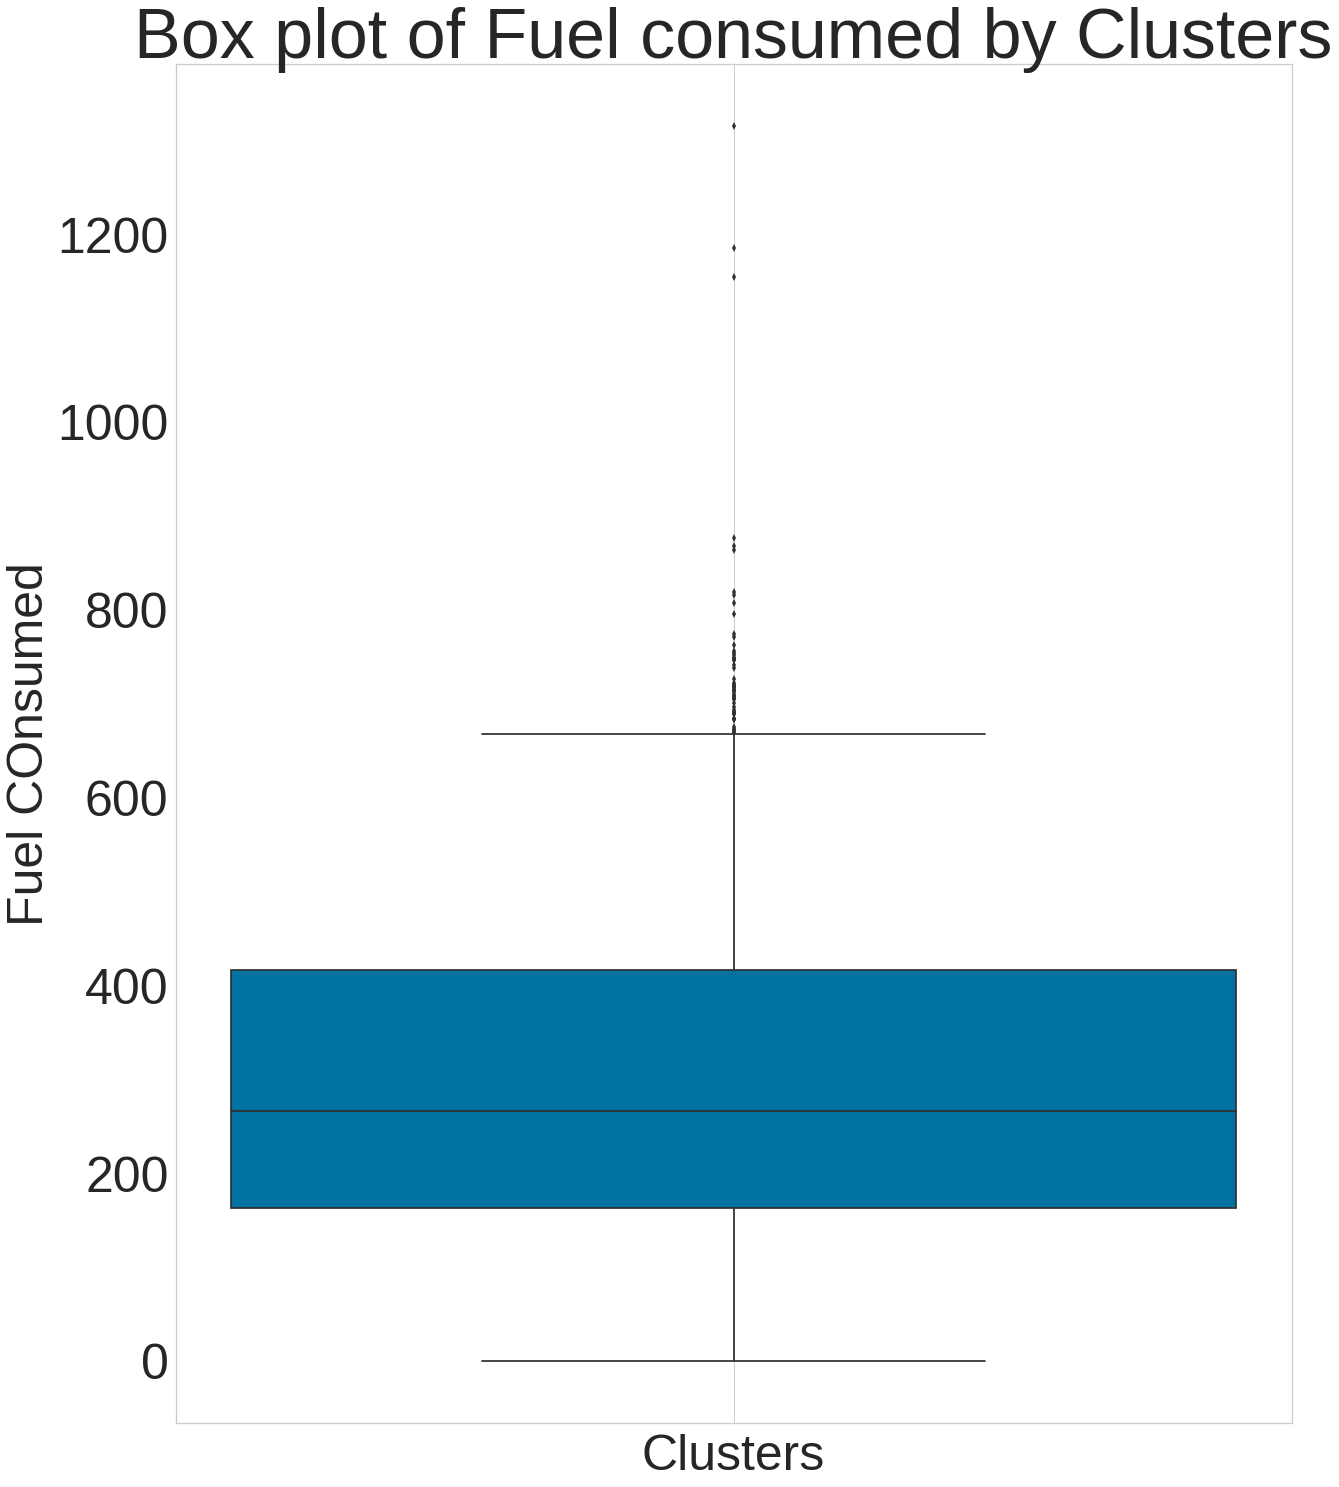

In [7]:
plt.figure(figsize = (20,25))
sns.boxplot( y= "CONSUMPTION_HIS",data=Data,saturation=10, width=0.9, fliersize=5, whis=1)
plt.title('Box plot of Fuel consumed by Clusters', fontsize=70)
plt.xlabel( "Clusters",fontsize=50)
plt.xticks(fontsize=50, rotation=90)
plt.grid()
plt.yticks(fontsize=50, rotation=None)
plt.ylabel( "Fuel COnsumed",fontsize=50)
plt.show()

A number of clusters have a minimum of zero fuel consumed and outliers values. KOUSSERI and MORA Cluster have symmetrical distribution on the fuel consumed. Fuel consumed by Ngaoundere 2 have negatively skewed distribution with  extreme outliers. GAROUA 2 and KAELE have positively skewed distribution. Meiganga 2 have extremely positively skewed distribution with a total fuel of 3020 consumed between within the six months.

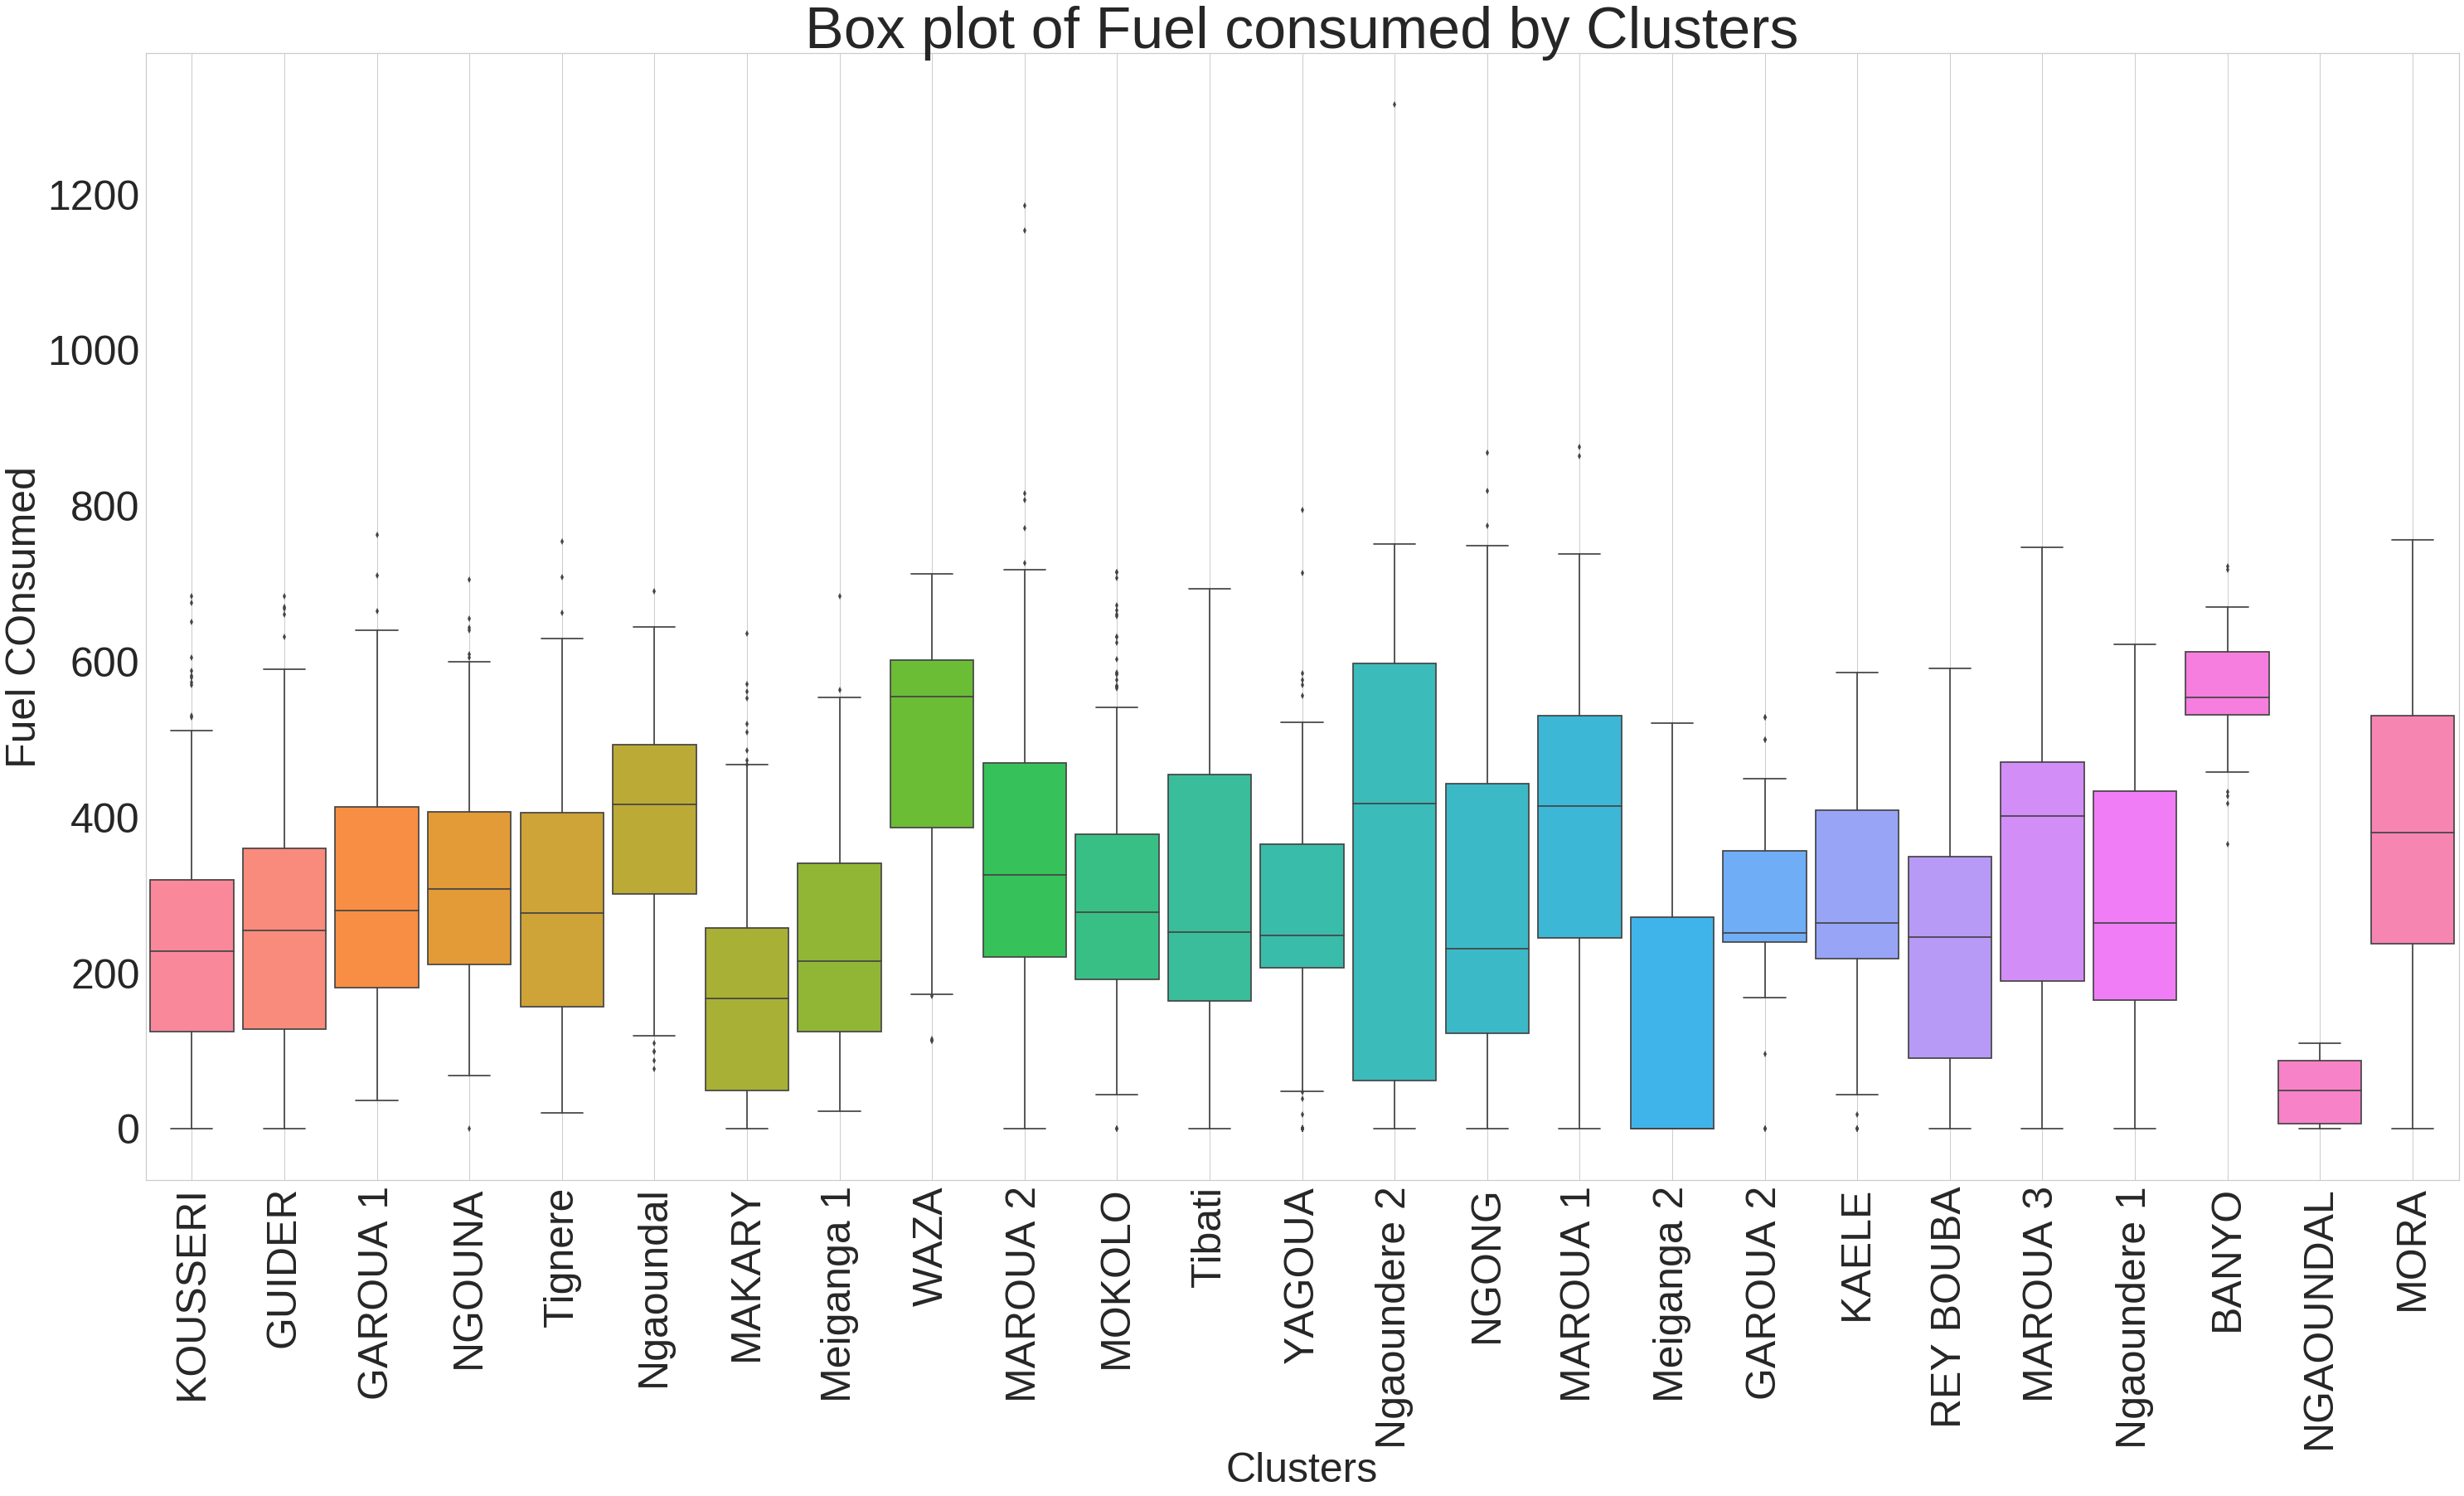

In [8]:
plt.figure(figsize = (50,25))
sns.boxplot(x="Cluster", y= "CONSUMPTION_HIS",data=Data,saturation=10, width=0.9, fliersize=5, whis=1)
plt.title('Box plot of Fuel consumed by Clusters', fontsize=70)
plt.xlabel( "Clusters",fontsize=50)
plt.xticks(fontsize=50, rotation=90)
plt.grid()
plt.yticks(fontsize=50, rotation=None)
plt.ylabel( "Fuel COnsumed",fontsize=50)
plt.show()

The fuel consumed by generator only sites has asymmetry distribution of the probabilities .The mean and standard deviation calculated from the fuel consumed data is  291.11 and 181.54 respectively. The positive skewness of the frequency distribution of 0.46 is as a result of the outliers hence deviating from the mean. Karl Pearson
(1895) , considered skewness as a measure of standardizing the difference between the mean and the mode.  From the box plot above, the minimum fuel consumed in most of the cluster is zero. This is clearly indicated in the normal distribution curve as the curve starts above the normal line. The outliers and the zero consumptions cases indicated the anomalies in the data collected.

In [9]:
 Data.groupby('Months',sort = False)['CONSUMPTION_HIS'].describe()

,count,mean,std,min,25%,50%,75%,max
Months,,,,,,,,
September,74.0,228.599595,149.516646,0.0,105.0825,218.650,337.840,535.00
October,457.0,289.663151,177.498245,0.0,146.0100,264.000,430.100,864.00
November,454.0,298.055793,196.883228,0.0,144.0000,272.205,453.625,876.00
December,477.0,295.643836,194.888414,0.0,163.3000,268.000,432.000,1185.35
January,409.0,268.867066,179.614097,0.0,149.1500,247.200,379.940,868.40
February,393.0,308.788015,170.935919,0.0,187.2000,288.000,411.340,753.60
March,412.0,296.285243,165.688756,0.0,184.2000,275.400,406.725,1315.60


In [10]:
 Data.groupby('Cluster',sort = False)['CONSUMPTION_HIS'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
KOUSSERI,199.0,231.575879,154.678732,0.00,124.4500,228.00,319.5000,684.00
GUIDER,177.0,259.182486,161.797870,0.00,127.5000,254.80,360.0000,684.00
GAROUA 1,115.0,299.525565,162.098378,36.00,181.1500,280.00,413.5500,762.50
NGOUNA,110.0,317.960182,147.673965,0.00,211.0000,307.75,407.2825,705.00
Tignere,148.0,287.576149,163.522268,20.00,156.8500,277.30,406.3250,753.60
Ngaoundal,75.0,392.605600,142.275852,76.93,301.9350,416.05,493.0000,689.70
MAKARY,197.0,176.188832,143.478440,0.00,49.0000,167.00,258.3000,636.00
Meiganga 1,100.0,245.228500,146.463494,23.00,124.8000,215.05,341.4000,684.00
WAZA,54.0,487.885185,168.921025,112.70,386.9750,555.45,601.9500,713.00


In [11]:
63.34/100*2676

1694.9784000000002

In [12]:
1694+981

2675

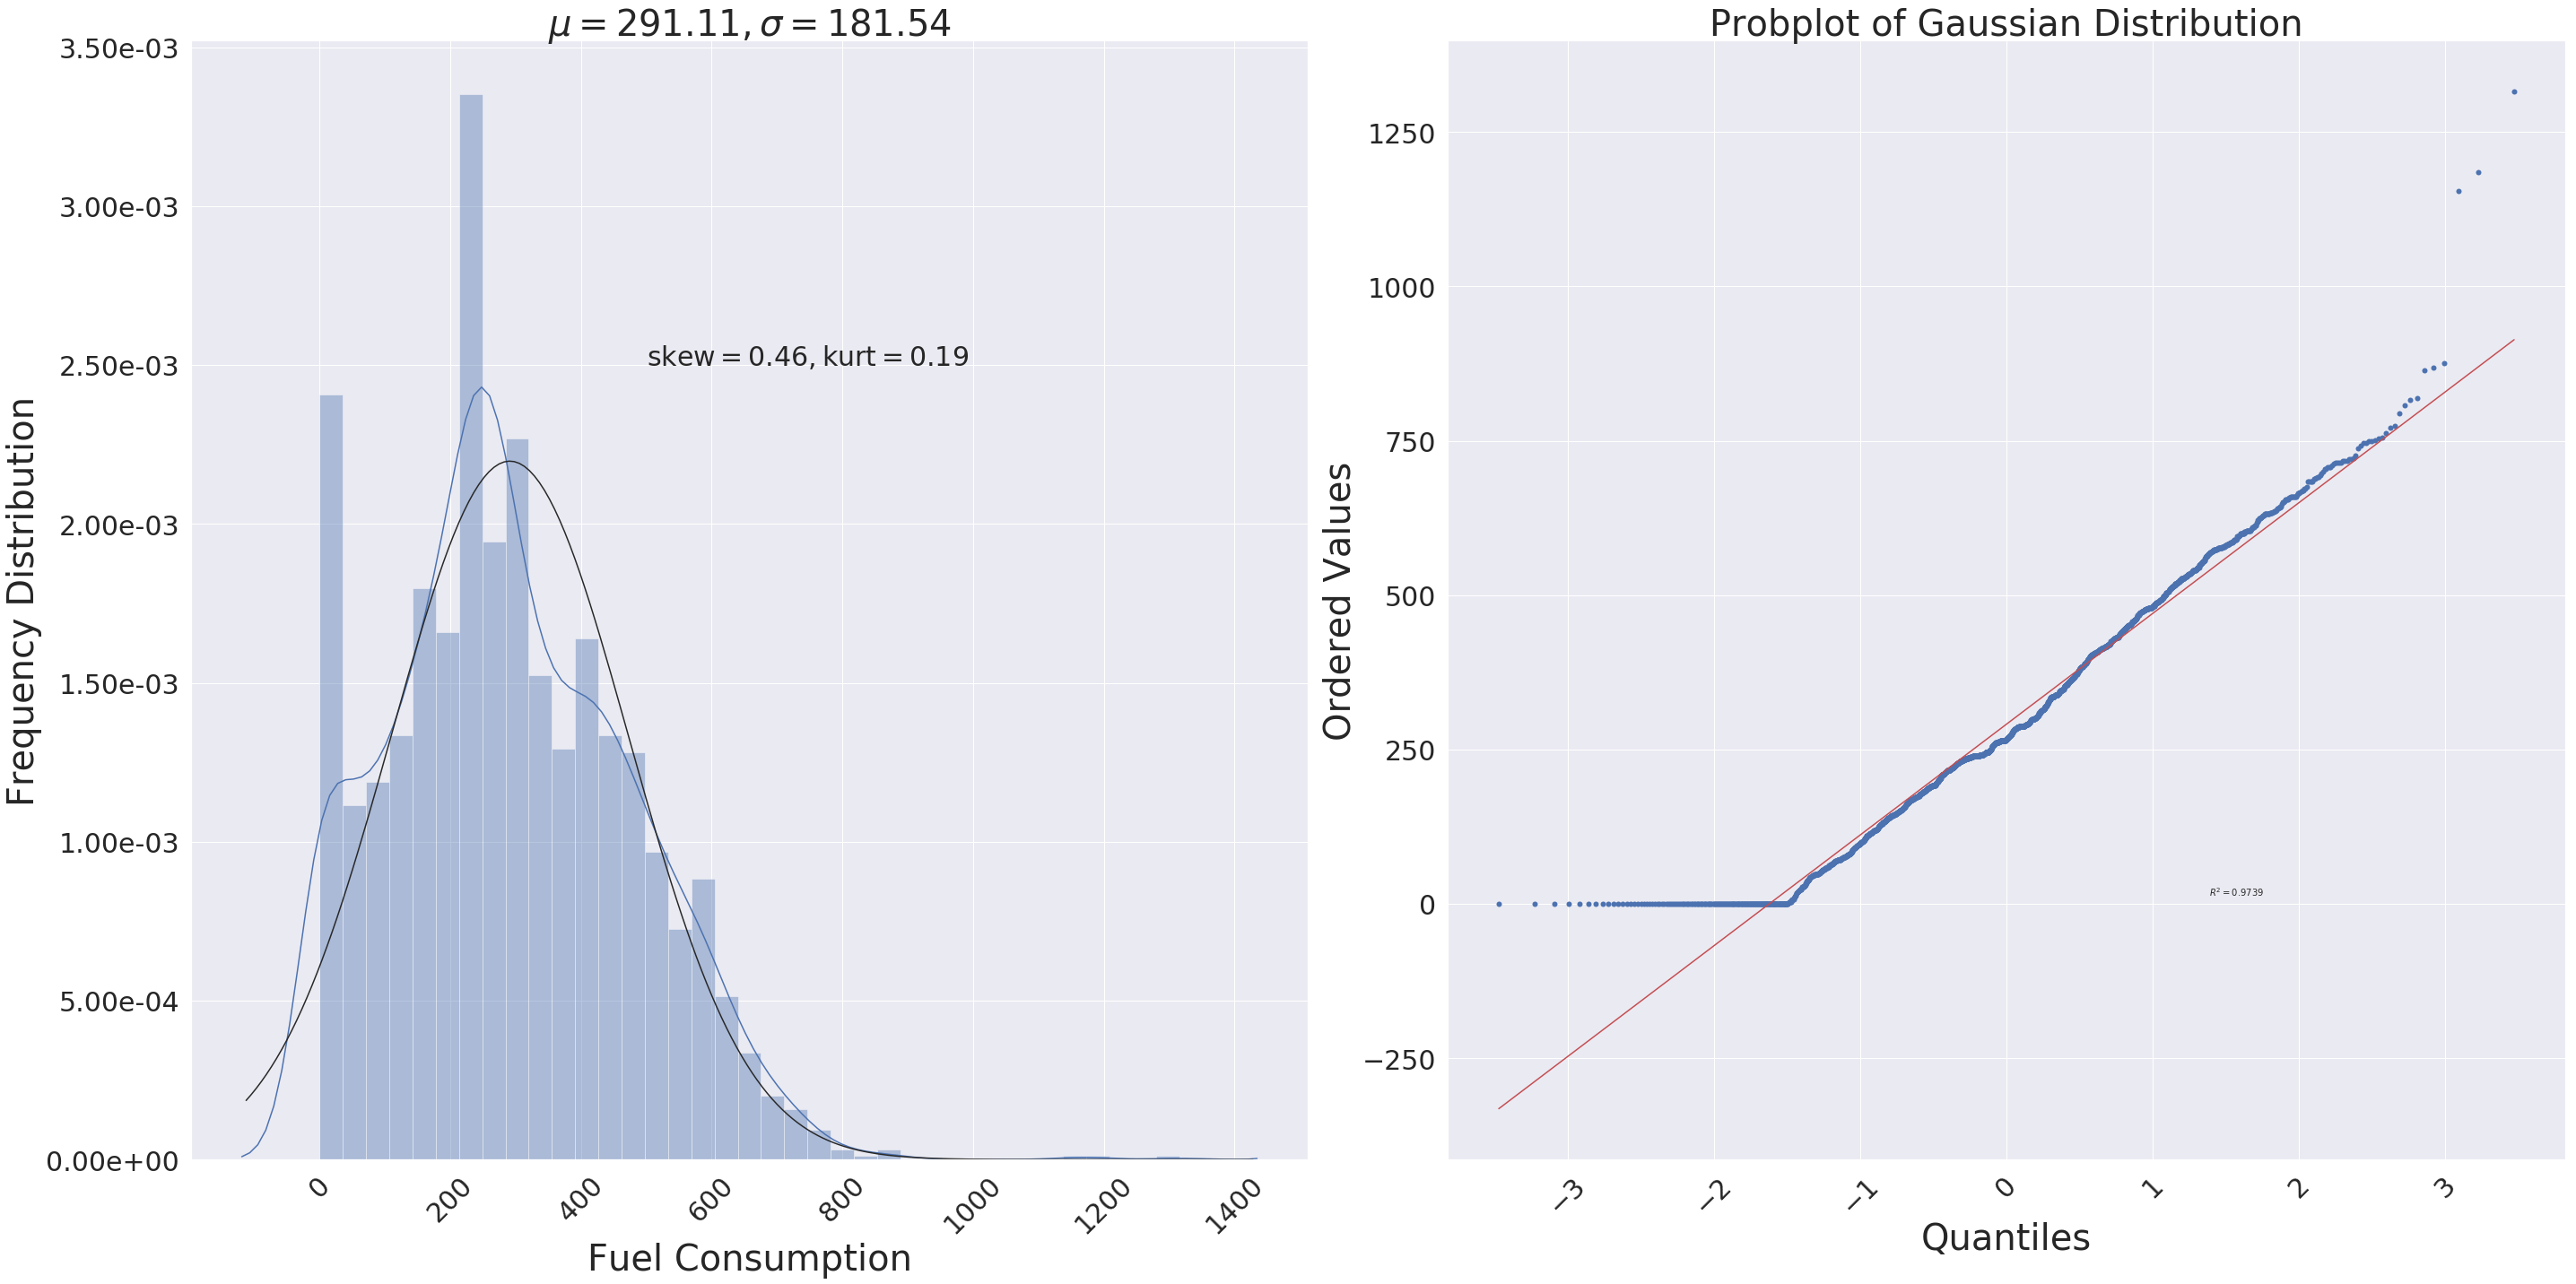

In [13]:
kk = Data['CONSUMPTION_HIS']
import matplotlib.ticker as mtick
from scipy import stats
from scipy.stats import skew,norm
import seaborn; seaborn.set()
%matplotlib inline

fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(121)
# kernel density plotsome scatter
ax1 = sns.distplot(kk,fit=norm, kde=True, norm_hist=True);
(mu, sigma) = norm.fit(kk);
ax1.set_title(r'$\mu = %0.2f, \sigma = %0.2f$' %(mu, sigma), fontsize=40)
ax1.set_ylabel(r'Frequency Distribution',fontsize=40)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.set_xlabel(r'Fuel Consumption',fontsize=40)
plt.xticks(fontsize=30, rotation=45)
plt.yticks(fontsize=30, rotation=None)
plt.text(x=500, y= 2.5e-03, s=r'$\rm skew = %0.2f, kurt = %0.2f$' %(kk.skew(), 
                                                                kk.kurt()), fontdict=None, withdash=False,
         fontsize=30)

ax = fig.add_subplot(122)
res = stats.probplot(kk, plot=plt,rvalue=True)
ax.set_title(r'Probplot of Gaussian Distribution',fontsize=40)
ax.set_ylabel(r'Ordered Values', fontsize=40)
ax.set_xlabel(r'Quantiles', fontsize=40)
plt.xticks(fontsize=30, rotation=45)
plt.yticks(fontsize=30, rotation=None)
plt.tight_layout()



 Data Set
 
The data set has entry from the field on how generator consumed fuel.  The data has observation on the sites that depend on the generator only to power the base station. 

Conditions

1. Generator can only work for at most 24 hours in one day.
2. When the RUNNING_TIME of the generator in the data set  is zero that is, zero fuel consumed. Then the fuel left in the tank of the generator and what was found during the next visit should be equal.  
3. The fuel generator consumed in one day  should not exceed the maximum fuel it can  consume in one day given the rate of consumption. 

 The above stated conditions are to be confirmed in the data collected using the code below. Two classes are generated as whether the information provided is legit or fraudulent.

In [14]:
a = list(Data['RUNNING_TIME'])
b = list(Data['QTE_Consumed_btn_visit'])
c = []
for i in range(len(a)):
    if a[i] == 0  and  b[i]!=0:
        c.append(1)
    else:
        c.append(0)
        
k = list(Data['Running_time_per_day'])
v = []
for i in range(len(k)):
    if k[i] > 24 or 0:
        v.append(1)
    else:
        v.append(0)
        
t = list(Data['Maximum_consumption_perDay'])
r = list (Data['DailyConsumption'])
z = []
for i in range(len(r)):
    if r[i] > t[i]:
        z.append(1)
    else:
        z.append(0)
        
        
p = []
for i in range(len(z)):
    if c[i]==0 and z[i]==0 and v[i]==0:
        p.append(0)
    else:
        p.append(1)    
Data['Class'] = p
Data['Class'].unique()

array([0, 1])

The graph below indicates the RUNNING_TIME in one day of different observation. In the sites where the generator is the only  source of power. Out of 2676 observations collected in a period of six months,
771 observation indicated that generator was running for more than 24 hours in one day, this is a pattern that indicates the cumulative time indicates as the total RUNNING_TIME of the generator in one is not true.This anomalies indicated that the information provided about the RUNNING_TIME was wrong. The trend of different generator RUNNING_TIME is as shown.

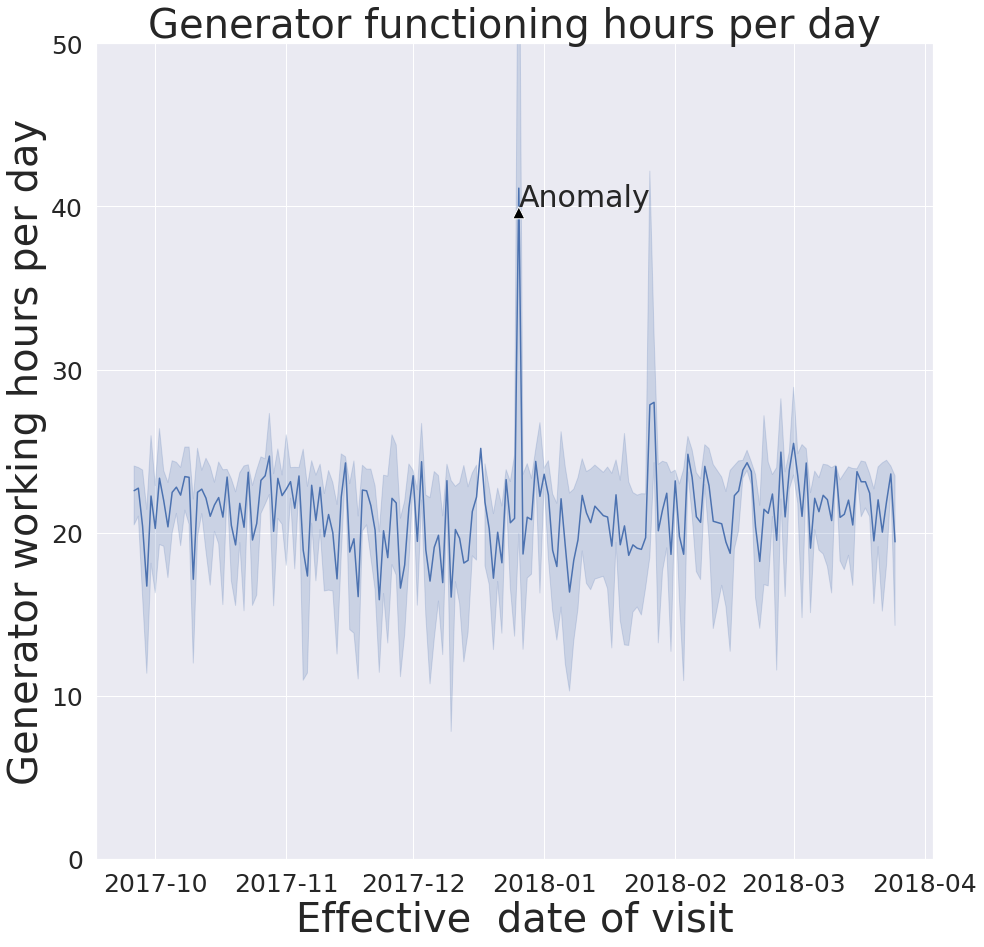

In [15]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['font.size'] = 30
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 50,2)
plt.annotate('Anomaly', xy=('2017-12-26', 40),
           arrowprops=dict(facecolor='black', shrink=0.05)) 
ax = sns.lineplot(y='Running_time_per_day', x='EFFECTIVE_DATE_OF_VISIT', markers=True,data=Data)
ax.set_title(r'Generator functioning hours per day',fontsize=40)
ax.set_ylabel(r'Generator working hours per day', fontsize=40)
ax.set_xlabel(r'Effective  date of visit', fontsize=40) 
plt.grid(True);

Text(0.5,0,'Effective  date of visit')

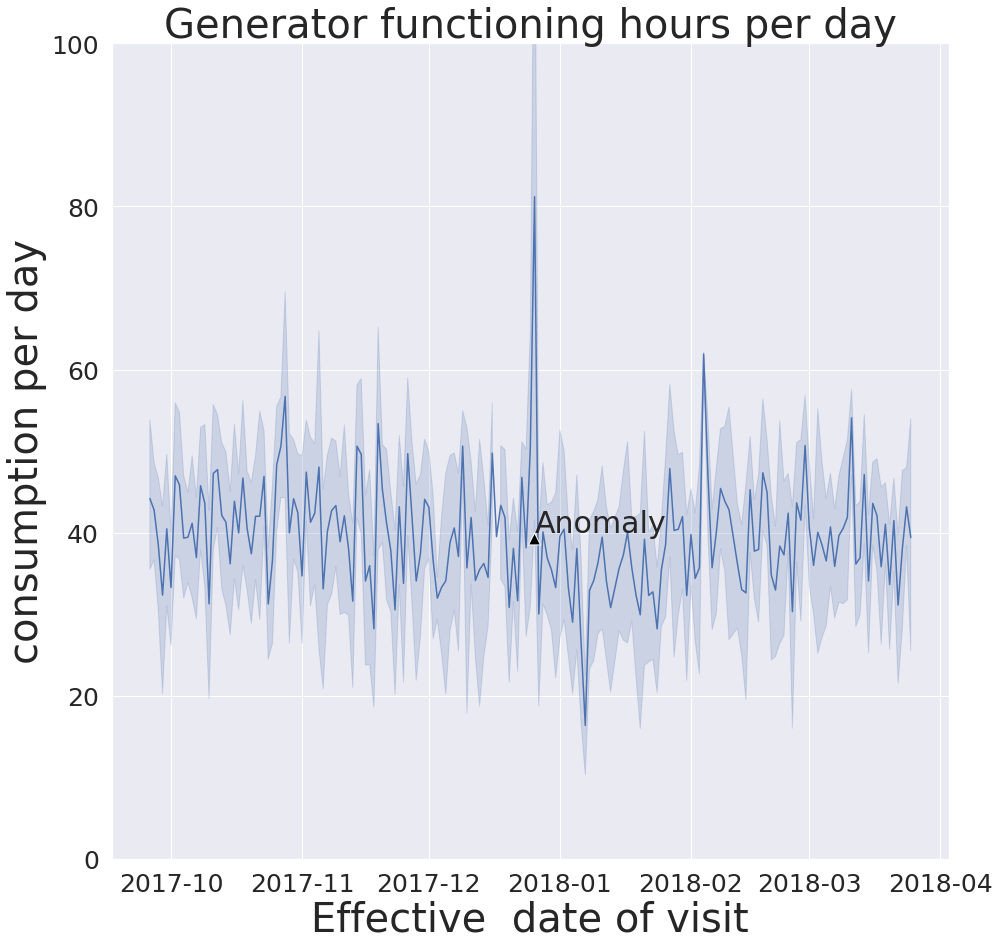

In [16]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['font.size'] = 30
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 100,10)
plt.annotate('Anomaly', xy=('2017-12-26', 40),
           arrowprops=dict(facecolor='black', shrink=0.05)) 
ax = sns.lineplot(y='DailyConsumption', x='EFFECTIVE_DATE_OF_VISIT', markers=True,data=Data)
ax.set_title(r'Generator functioning hours per day',fontsize=40)
ax.set_ylabel(r'consumption per day', fontsize=40)
ax.set_xlabel(r'Effective  date of visit', fontsize=40) 


In [17]:
# plt.figure(figsize = (15,15)) 
# plt.plot( Data['Running_time_per_day'], linestyle = '-')
# plt.axhline(24, color='r')
# plt.title('Anomaly on the Running_time_per_day', fontsize = 25)
# plt.xlabel('Sample size', fontsize = 25)
# plt.ylabel('Running hours per day', fontsize = 25)
# plt.xticks(fontsize=15, rotation=None)
# plt.yticks(fontsize=15, rotation=None)
# plt.ylim(0,40,2)
# plt.show()

## Class Label

Class imbalance affect most classification algorithms. The majority class can overtake the algorithm making it to predict only one class with high accuracy. Out of 2676 samples, the sample has 36.66 percent  label of fraud class and 63.34 label of legit class. Class imbalance can be corrected by either under-sampling of legit class, that is , reducing the size of the legit observation into the same size as the fraudulent class or oversampling of the fraudulent class to make multiple observation of the fraudulent class to level both classes into the same sample size.

In [18]:
Valid = Data[Data['Class'] == 0]
Fraud =  Data[Data['Class'] == 1]
Fraud_percent = len(Fraud['Class'])/len(Data['Class'])*100
Valid_percent =len(Valid['Class'])/len(Data['Class'])*100

print('Fraud cases:{}'.format(len(Fraud)), 'Fraud cases percentage:{}'.format(Fraud_percent))
print('Valid cases:{}'.format(len(Valid)), 'Valid cases percentage:{}'.format(Valid_percent))
# classes = ('Valid', 'Fraud')
# y_pos = np.arange(len(classes))
# p = [1695, 981]
# plt.figure(figsize = (10,10))  
# seaborn.barplot(y_pos,p)
# plt.xticks(y_pos, classes)
# plt.ylabel('Sample size',fontsize = 20)
# plt.xlabel('',fontsize = 20)
# plt.title('Classification Class Distribution', fontsize = 20)
 
# plt.show()

Fraud cases:981 Fraud cases percentage:36.65919282511211
Valid cases:1695 Valid cases percentage:63.34080717488789


In [19]:
# plt.title('Classification Class Distribution', fontsize = 20)
# plt.xlabel('',fontsize = 20)
# plt.ylabel('Sample size',fontsize = 20)
# ax = sns.countplot(x="Class", data=Data)

0    1695
1     981
Name: Class, dtype: int64


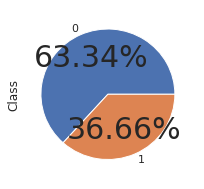

In [20]:
plt.figure(figsize=(3,3))
print(pd.Series(Data['Class']).value_counts())
pd.Series(Data['Class']).value_counts().plot(kind ='pie', autopct='%1.2f%%')
plt.show()

The correlation matrix measures the linear relationship between variable in the data set. With strong collection between variable and itself indicated as one and no relation or little relation indicated as zero. Some variable such as the rate of consumption and the NUMBER_OF_DAYS between the visits. There is a positive correlation of 0.81 between total fuel consumed and the number of hours the generator has been running.

In [21]:
correlation?

Object `correlation` not found.


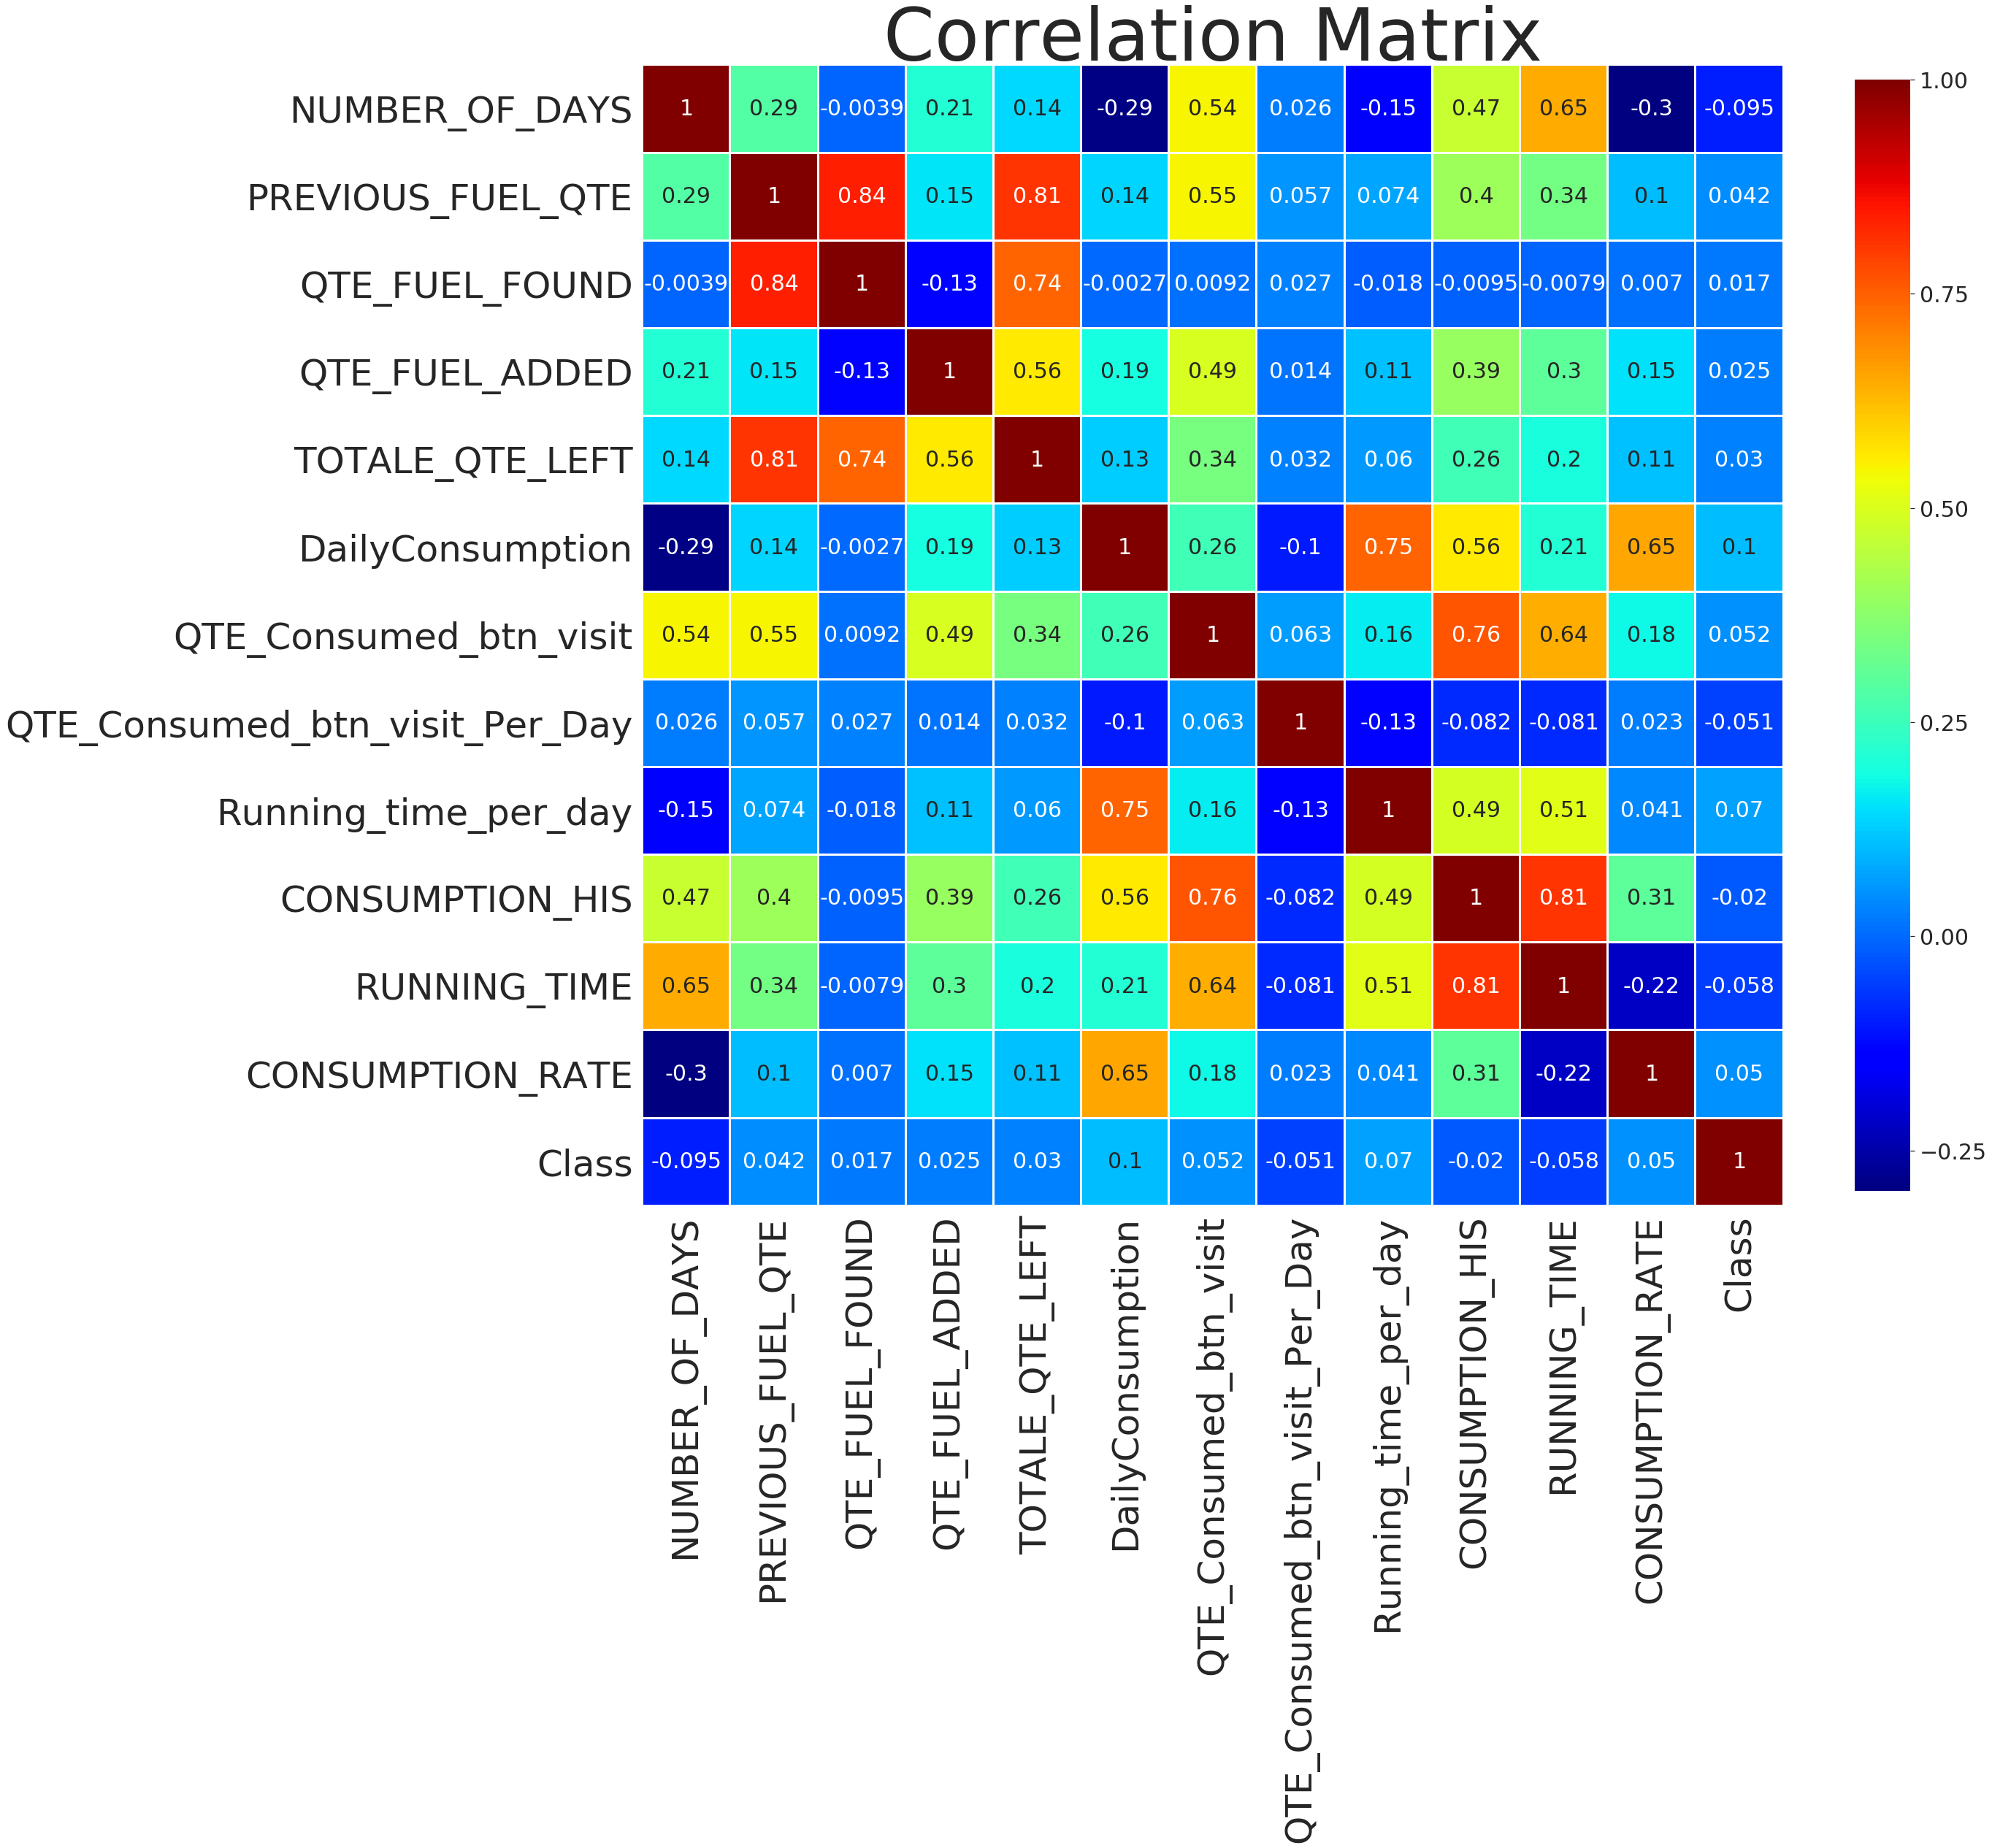

In [22]:
# Correlation heatmap
correlation = Data[['NUMBER_OF_DAYS','PREVIOUS_FUEL_QTE', "QTE_FUEL_FOUND",'QTE_FUEL_ADDED'
                    ,'TOTALE_QTE_LEFT','DailyConsumption',
       'QTE_Consumed_btn_visit','QTE_Consumed_btn_visit_Per_Day', 'Running_time_per_day',
                    'CONSUMPTION_HIS','RUNNING_TIME' ,'CONSUMPTION_RATE','Class']].corr()  
DATA = Data[['NUMBER_OF_DAYS','PREVIOUS_FUEL_QTE', "QTE_FUEL_FOUND",'QTE_FUEL_ADDED'
                    ,'TOTALE_QTE_LEFT','DailyConsumption',
       'QTE_Consumed_btn_visit','QTE_Consumed_btn_visit_Per_Day', 'Running_time_per_day',
                    'CONSUMPTION_HIS','RUNNING_TIME' ,'CONSUMPTION_RATE']]
YY = Data[['Class']]
plt.figure(figsize = (35,35))  
plt.title("Correlation Matrix", fontsize= 100)
plt.xticks(fontsize=50, rotation=45)
plt.yticks(fontsize=50, rotation=None)
plt.rcParams['font.size'] = 30
ax=sns.heatmap(correlation, vmax=1, square=True,  linewidths=2,annot=True, cmap='jet',
           cbar_kws={"shrink": 0.8})  #cubehelix 
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=30)
# ax.figure.axes[-1].yaxis.label.set_size(20)
plt.show()

In [23]:
SS = Data[['NUMBER_OF_DAYS', 'CURRENT HOUR METER GE1',
       'PREVIOUS HOUR METER G1', 'PREVIOUS_FUEL_QTE', 'QTE_FUEL_FOUND',
       'QTE_FUEL_ADDED', 'TOTALE_QTE_LEFT', 'CONSUMPTION_HIS',
       'RUNNING_TIME', 'CONSUMPTION_RATE',
        'DailyConsumption','QTE_Consumed_btn_visit','QTE_Consumed_btn_visit_Per_Day', 'Running_time_per_day',
       'Maximum_consumption_perDay', 'GENERATOR_1_CAPACITY_(KVA)']]

# Feature Importances

From Gradient boosting feature selection the number of hours the generator is running per day and the fuel  consumed per day has higher influence in the classification class. Quantity of fuel added and total fuel left does not explain the classification class. 

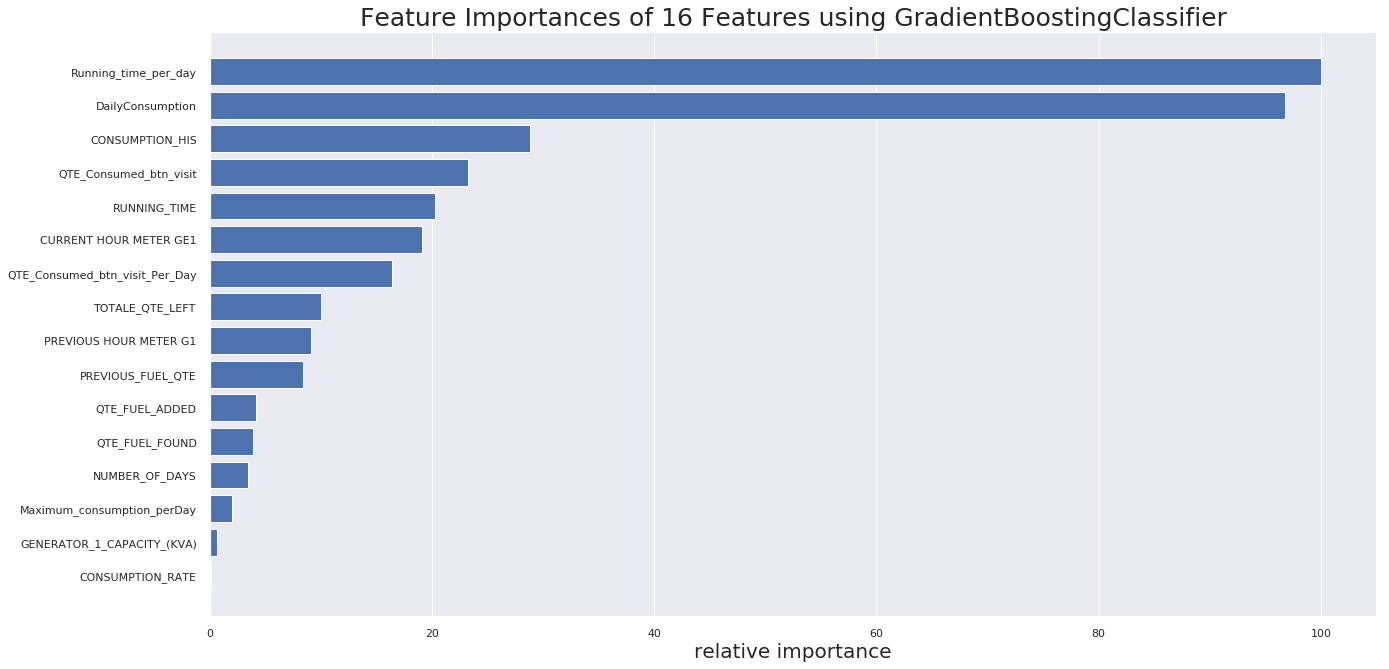

In [24]:


y = Data["Class"]
x_train, x_test, y_train, y_test = train_test_split(SS, y, test_size=0.3, random_state=42)
GB = GradientBoostingClassifier()    
GB = GB.fit(SS,y)
# Create a new matplotlib figure
#plt.rcParams['font.size'] = 100
fig = plt.figure(figsize = (20,10))
viz = FeatureImportances(GradientBoostingClassifier(), fontsize=100)
viz.fit(SS, y)
#plt.xticks(fontsize=20, rotation=None)
#plt.yticks(fontsize=20, rotation=None)
plt.xlabel("Relative Importance" ,fontsize =20)
plt.title('Feature Importances Using Gradient Boosting Classifier')
plt.rcParams['axes.titlesize'] = 25
# fig.suptitle('test title')
#plt.rcParams['legend.fontsize'] = 30
#plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
viz.poof()



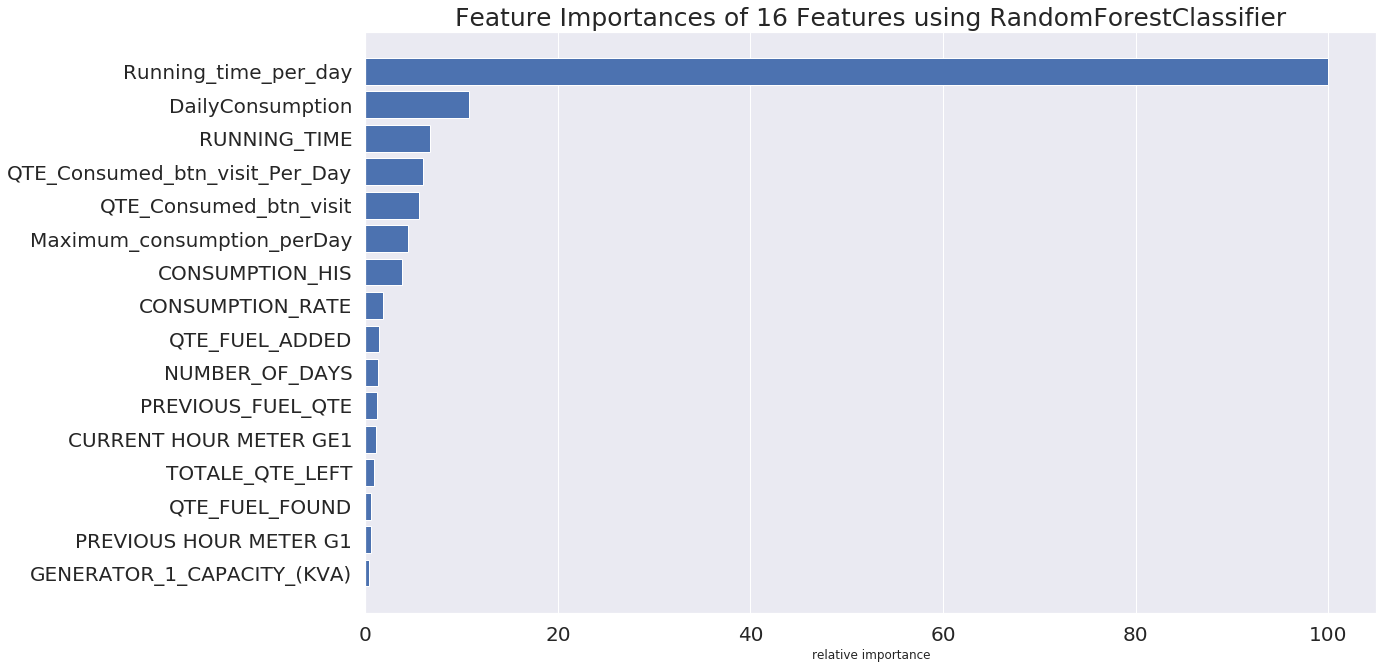

In [25]:
x_train, x_test, y_train, y_test = train_test_split(SS, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=43)      
rf = rf.fit(SS,y)
# Create a new matplotlib figure
plt.figure(figsize = (20,10))  
#ax = fig.add_subplot()
viz = FeatureImportances( RandomForestClassifier(random_state=43) )
viz.fit(SS, y)

viz.poof()

In [26]:
# data = Data[[ 'CONSUMPTION_RATE ','DailyConsumption',
#        'QTE_Consumed_btn_visit_Per_Day', 'Running_time_per_day',
#        'Class']]
#Data['Class'] = p

data = Data[['Running_time_per_day','DailyConsumption',
             'CONSUMPTION_HIS', 'RUNNING_TIME' , 'Class']]


In [27]:
# FUNCTION TO MAKE PREDICTIONS

def predictmodel(model):
    y_pred = model.predict(x_test)
    f,t,thresholds = metrics.roc_curve(y_test,y_pred)
    cm = metrics.confusion_matrix(y_test,y_pred)
    print("Score:", metrics.auc(f,t))
    print("Classification report:")
    print(metrics.classification_report(y_test,y_pred))
    print("Confusion Matrix:")
    print(cm)

# # Support Vector Classifier

Support Vector Classifier is an algorithm used for classification by having an hyperplane between the two class class. The support vector classifier maximize the margin between the two class. The parameter C(cost) and gamma have a great influence on the performance of the model in terms of accuracy.
The parameter C is a penalty parameter in case of misclassification. The large the C the lower the misclassification rate, that is,the model ensure all the train data set are correctly classified  but also can poss an overfitting threat. Lower C allows misclassification with a slack variable error.
The gamaa parameter explains how a single input have a influence in the model, low gamma means a single input have low influence in the model.

In the case the class is non separable the class. slack variable is introduced to the model that allows misclassification of the model. 

In the case a class is not linearly separable a non linear kernel function are used to separate the two class. This includes radial, exponential and polynomial kernel. 

With a non linear kernel , radial, we fit the model with first four importance variables from feature selection. Classification classes; class 0:- normal , class 1:-anomaly. With an optimal grid search of parameter C = 1000 and gamma 0.001. The model had an accuracy of 94% . Out of 536 test data, 313 were correctly predict as positive(True Positive) and 15 misclassified as positive(False positive) and out of 208 fraud sample, 192 was correctly classified(True Negative) and 16(False Negative). From the receiver operating characteristic ,the Area under the curve of the support vector classifier is 97%.The Mathew correlation Coeffient value for the SVC is rated at 0.87 . 

## GRID SEARCH

In [28]:
# # Set the parameters by cross-validation
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# scores = ['precision', 'recall']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
#                        scoring='%s_macro' % score)
#     clf.fit(x_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))

Score: 0.93867260788
Classification report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       328
          1       0.93      0.92      0.93       208

avg / total       0.94      0.94      0.94       536

Confusion Matrix:
[[313  15]
 [ 16 192]]


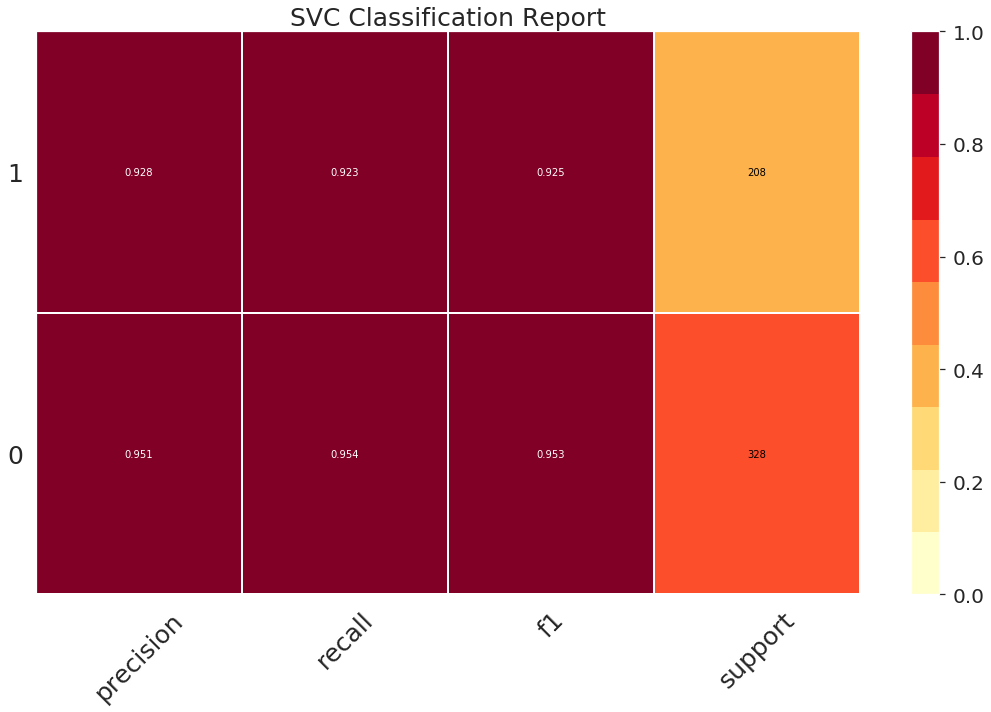

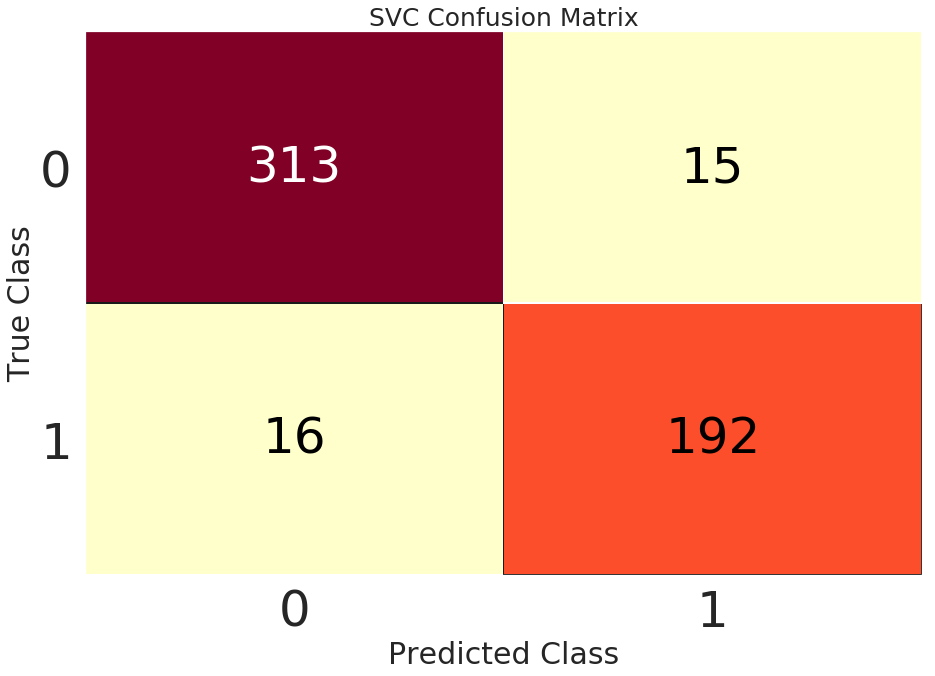

In [29]:
x = data.loc[:,data.columns.tolist()[0:4]]
x = x.as_matrix()
Y = data.loc[:,'Class']
Y = Y.as_matrix()
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size=0.20,random_state=2700) 
SVM =SVC(kernel="rbf", C=1000, gamma = 0.001, decision_function_shape=None, probability=True)
SVM.fit(x_train , y_train)
predictmodel(SVM)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
#plt.rcParams['font.size'] = 50
visualizer = ClassificationReport(SVM,cmap='YlOrRd', support=True)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)

visualizer.poof()
ax= plt.subplot()
cm = ConfusionMatrix(SVM, classes=[0,1], fontsize=50)
cm.fit(x_train, y_train, fontsize=50)
cm.score(x_test, y_test, fontsize=50)
plt.xticks(fontsize=50, rotation=None)
plt.yticks(fontsize=50, rotation=None)
plt.xlabel(r' ', fontsize=30)
plt.ylabel(r' ', fontsize=30)
#plt.title(r' ', fontsize=30)
ax.set_title('Confusion Matrix', fontsize=80); 
cm.poof(fontsize=50)



The parameter C plotted against accuracy. The accuracy  increases with an increases in C and stagnate after C= 400.

## Plot of accuracy against parameter C 

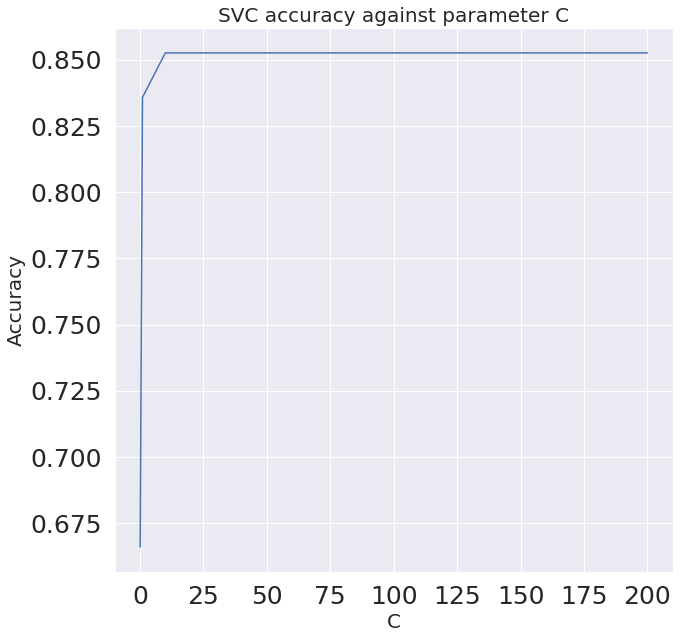

In [30]:
P = [0.1,1,10, 100,200]
L = []
jj = []
for i in range(len(P)):
    scv = SVC(C=P[i])   
    scv.fit(x_train, y_train)
    L.append(scv.score(x_test, y_test))
    jj.append(cross_val_score(scv, x_test, y_test).std())
#print(L)
#print(jj)
plt.figure(figsize = (10,10))
sns.lineplot(P,L)
plt.xlabel("C",  fontsize = 20)
plt.title("SVC accuracy against parameter C",  fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)
cm.poof()
plt.show()

## ROC Curve

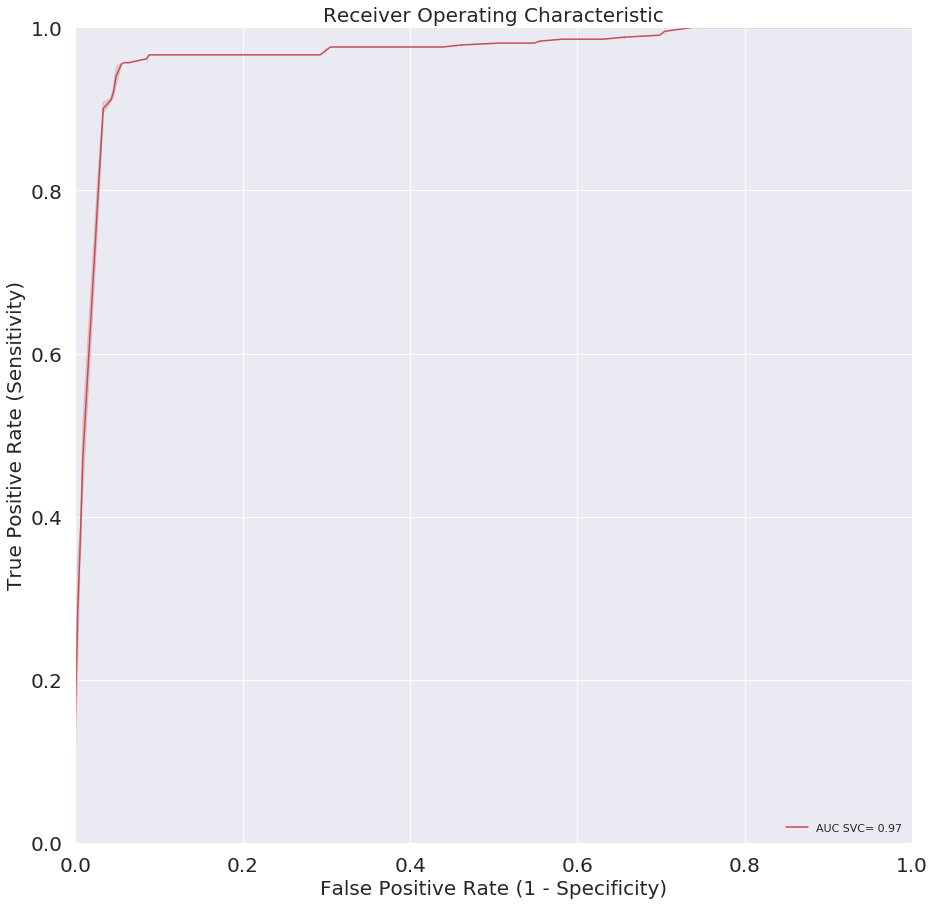

In [31]:
y_pred_prob = SVM.predict_proba(x_test)[:, 0]
y_pred_probs = SVM.predict_proba(x_test)[:, 1]
y_pred_probC = SVM.predict_proba(x_test)
y_pred= SVM.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)
Roc_Auc = auc(fpr, tpr)
plt.figure(figsize = (15,15))
sns.lineplot(fpr, tpr, color = 'r', label = 'AUC SVC= %0.2f' % Roc_Auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'lower right')
plt.rcParams['font.size'] = 12
plt.yticks(fontsize=20, rotation=None)
plt.xticks(fontsize=20, rotation=None)
plt.title('Receiver Operating Characteristic' , fontsize = 20)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 20)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 20)
plt.grid(True)
plt.show()

In [32]:
SVM.fit(x_train, y_train)  
SVM.score(x_train, y_train)
# Predictions/probs on the test dataset
SMpredicted = pd.DataFrame(SVM.predict(x_test))  
SMprobs = pd.DataFrame(SVM.predict_proba(x_test))
# Store metrics
svm_accuracy = metrics.accuracy_score(y_test, SMpredicted)  
svm_roc_auc = metrics.roc_auc_score(y_test, SMprobs[1])  
svm_confus_matrix = metrics.confusion_matrix(y_test, SMpredicted)  
svm_mcc = matthews_corrcoef(y_test, SMpredicted)  
svm_classification_report = metrics.classification_report(y_test,SMpredicted)  
svm_precision = metrics.precision_score(y_test, SMpredicted, pos_label=1)  
svm_recall = metrics.recall_score(y_test, SMpredicted, pos_label=1)  
svm_f1 = metrics.f1_score(y_test, SMpredicted, pos_label=1)
# Evaluate the model using 10-fold cross-validation
svm_cv_scores = cross_val_score(SVM, x_test, y_test, scoring='precision', cv=5)  
svm_cv_mean = np.mean(svm_cv_scores)
svm_cv_mean

0.77834586466165412

# # Nueral Network- MultiLayer Percetron (MLP)

This a nueral Network model use in classification. The input variable is a signed to a weight fuction and the product of the weight function and input variable is passed to the next layer where the non linear activation function is applied into the summation. The sigmoid activation functon have been used in most application of neural network.

## GRID SEARCH

In [33]:
def predictmodelMLP(model):
    y_pred = model.predict(x_tests)
    f,t,thresholds = metrics.roc_curve(y_tests,y_pred)
    cm = metrics.confusion_matrix(y_tests,y_pred)
    
    print("Score:", metrics.auc(f,t))
    print("Classification report:")
    print(metrics.classification_report(y_tests,y_pred))
    print("Confusion Matrix:")
    print(cm)

In [34]:
def f(x):
    return 1 / (1 + np.exp(-x))
f(0.6)

0.6456563062257954

In [35]:
def matrix_feed_forward_calc(n_layers, x, w, b):
    for l in range(n_layers-1):
        if l == 0:
            node_in = x
        else:
            node_in = h
        z = w[l].dot(node_in) + b[l]
        h = f(z)
    return h

Score: 0.922256097561
Classification report:
             precision    recall  f1-score   support

          0       1.00      0.84      0.92       328
          1       0.80      1.00      0.89       208

avg / total       0.92      0.90      0.91       536

Confusion Matrix:
[[277  51]
 [  0 208]]
Training set score: 0.976168
Test set score: 0.904851


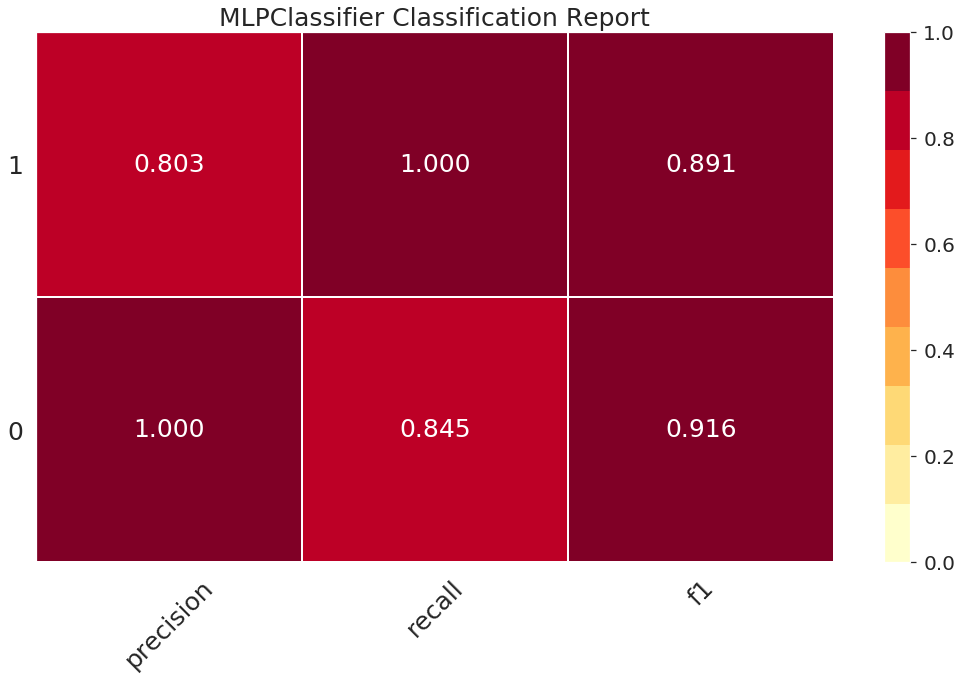

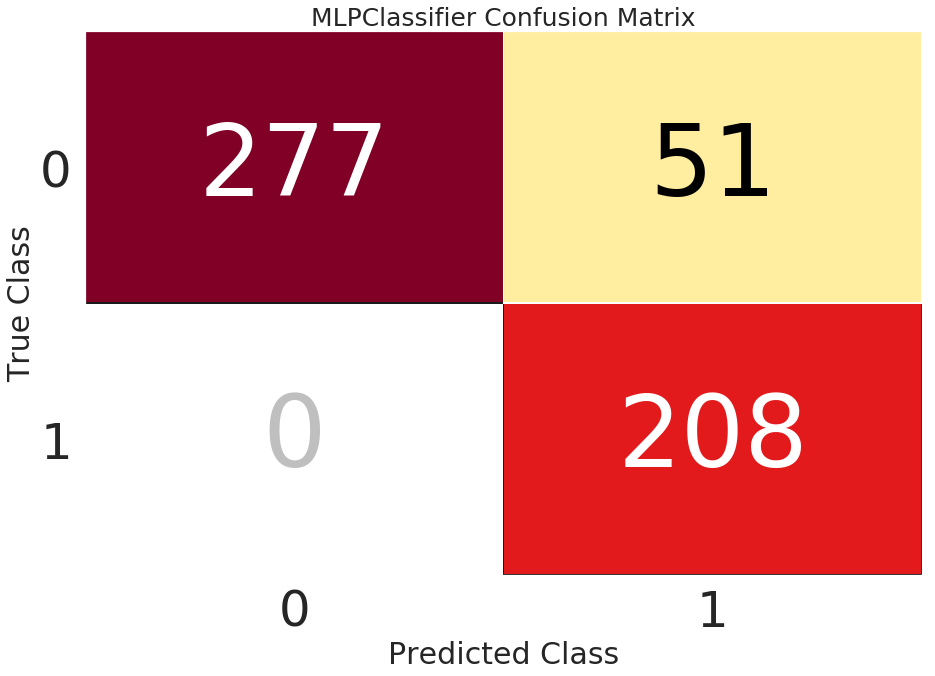

In [36]:
x = data.loc[:,data.columns.tolist()[0:4]]
x = x.as_matrix()
Y = data.loc[:,'Class']
Y = Y.as_matrix()
x_trains,x_tests,y_trains,y_tests = train_test_split(x,Y,test_size=0.2,random_state=2700)
scaler = StandardScaler()
scaler.fit(x_trains)
x_trains = scaler.transform(x_trains)
scaler.fit(x_tests)
x_tests = scaler.transform(x_tests) 

clf = MLPClassifier(solver='lbfgs' ,hidden_layer_sizes=(300,),beta_1=0,activation='relu' ,
    early_stopping=False,alpha=1e-05,momentum=0.9, learning_rate='constant',
random_state=2700)
History = clf.fit(x_trains, y_trains)

predictmodelMLP(clf)
print("Training set score: %f" % clf.score(x_trains, y_trains))
print("Test set score: %f" % clf.score(x_tests, y_tests))
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 25
visualizer = ClassificationReport(clf)
visualizer.fit(x_trains, y_trains)
visualizer.score(x_tests, y_tests)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)

visualizer.poof()
plt.rcParams['font.size'] = 50
cm = ConfusionMatrix(clf, classes=[0,1], fontsize=100)


cm.fit(x_trains, y_trains, cmap='plt.cm.RdYlGn')
cm.score(x_tests, y_tests)
plt.xticks(fontsize=50, rotation=None)
plt.yticks(fontsize=50, rotation=None)
plt.xlabel(r' ', fontsize=30)
plt.ylabel(r' ', fontsize=30)
cm.poof()


from sklearn.grid_search import RandomizedSearchCV
model =  MLPClassifier()


parameters = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7), 
              'hidden_layer_sizes':np.arange(5, 12), 'random_state':[0,1,2,3,4,5,6,7,8,9,100]}
clf_grid = GridSearchCV(model, parameters, n_jobs=-1)

grid_result = clf_grid.fit(x_trains, y_trains)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [37]:
# 'activation': 'relu',
#  'alpha': 0.01,
#  'early_stopping': False,
#  'hidden_layer_sizes': 2,
#  'learning_rate': 'invscaling',
#  'learning_rate_init': 0.01,
#  'max_iter': 500
clf1 = MLPClassifier(solver='lbfgs' ,hidden_layer_sizes=(300,),beta_1=0,activation='relu' ,
    early_stopping=False,alpha=1e-05,momentum=0.9, learning_rate='constant',
random_state=2700)
clf1.fit(x_trains, y_trains)

predictmodelMLP(clf1)

Score: 0.922256097561
Classification report:
             precision    recall  f1-score   support

          0       1.00      0.84      0.92       328
          1       0.80      1.00      0.89       208

avg / total       0.92      0.90      0.91       536

Confusion Matrix:
[[277  51]
 [  0 208]]


## ROC CURVE FOR MLP

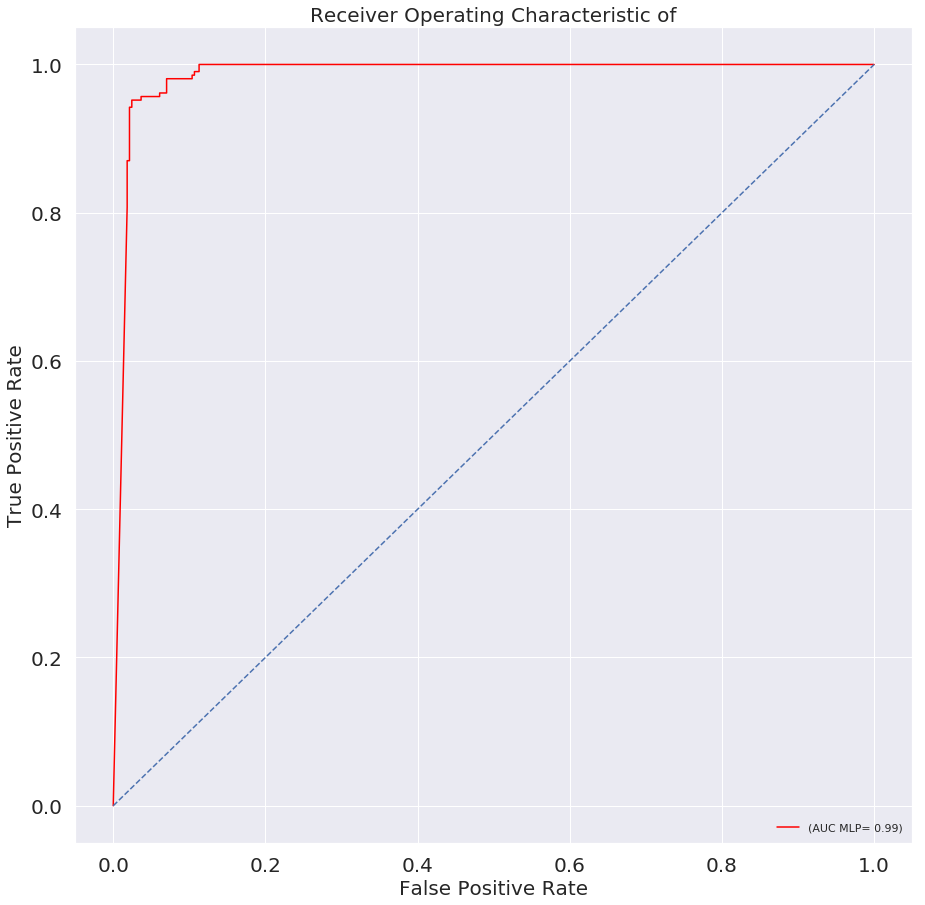

In [38]:
y_prob1 = clf.predict_proba(x_tests)[:,1]
y_prob0 = clf.predict_proba(x_tests)
y_prob2 = clf.predict_proba(x_tests)[:,0]
y_pred = clf.predict(x_tests)
clf.score(x_tests, y_pred)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_tests, y_prob1)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic of', fontsize = 20)
plt.plot(false_positive_rate,true_positive_rate, color='red',label = '(AUC MLP= %0.2f)' % roc_auc)
#plt.plot(fpr, tpr, color = 'g',label = 'AUC SVC= %0.2f' % Roc_Auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate', fontsize = 20)
plt.grid(True);
plt.xlabel('False Positive Rate',fontsize = 20)
plt.show()

In [39]:
clf.fit(x_trains,y_trains)
clf.score(x_trains, y_trains)  
# Predictions on the test dataset
MLPpredicted = pd.DataFrame(clf.predict(x_tests))  
# Probabilities on the test dataset
MLPprobs = pd.DataFrame(clf.predict_proba(x_tests))  
MLPprob0= pd.DataFrame(clf.predict_proba(x_tests)[:, 0])
MLPprob1 = pd.DataFrame(clf.predict_proba(x_tests)[:, 1])
MLP_accuracy= metrics.accuracy_score(y_tests, MLPpredicted)  
MLP_mcc = matthews_corrcoef(y_tests, MLPpredicted) 
MLP_precision = metrics.precision_score(y_tests, MLPpredicted, pos_label=1)  
MLP_recall = metrics.recall_score(y_tests, MLPpredicted, pos_label=1)  
MLP_f1 = metrics.f1_score(y_tests, MLPpredicted, pos_label=1)
#CROSS VAL
MLP_cv_scores = cross_val_score(clf , x_tests, y_tests, scoring='precision', cv=10)  
MLP_cv_mean = np.mean(MLP_cv_scores)
set_printoptions(precision=3)
MLP_cv_mean
MLP_cv_scores

array([ 0.947,  0.913,  0.913,  1.   ,  0.909,  0.875,  0.875,  0.913,
        0.9  ,  0.909])

In [40]:
SVM

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Logistic regression Classifier

This is a probabilistic model for classification with nominal dependent variable. The logistic model classifier an input variable based on the probalilty of the class. 

## GRID SEARCH

In [41]:
# model2 =LogisticRegression()
# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)
# lrs = GridSearchCV(model2, hyperparameters, cv=5, verbose=0)
# lrs.fit(X, y)
# best_model = lrs.fit(X, y)
# print(lrs.best_params_)
# # View best hyperparameters
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])

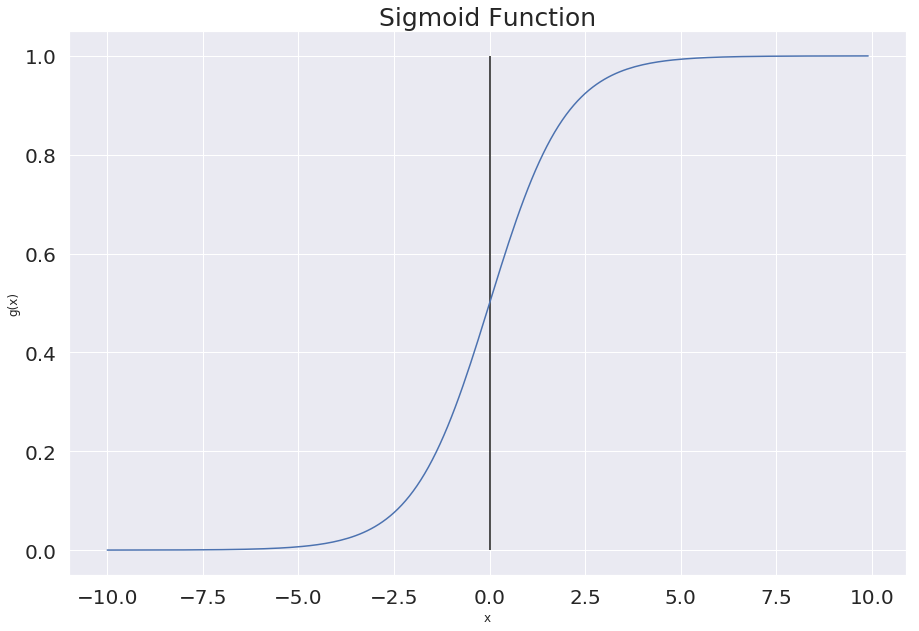

In [42]:
import matplotlib.pylab as plt
import numpy as np
x = np.arange(-10, 10, 0.1)
f = 1 / (1 + np.exp(-x))
plt.plot(x, f)
plt.vlines([0], 0, 1)
plt.xlabel('x')
plt.title('Sigmoid Function')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()


In [43]:
def predictmodelLR(model):
    y_pred = model.predict(x_testl)
    f,t,thresholds = metrics.roc_curve(y_testl,y_pred)
    cm = metrics.confusion_matrix(y_testl,y_pred)
    
    print("Score:", metrics.auc(f,t))
#     print("Classification report:")
    print(metrics.classification_report,y_testl,y_pred)
    print("Confusion Matrix:")
    print(cm)

In [44]:
xl = data.loc[:,data.columns.tolist()[0:4]]
#xl = x.as_matrix()
Yl = data.loc[:,'Class']
#Yl = Y.as_matrix()
scaler = StandardScaler()
scaler.fit(xl)
x_trainl,x_testl,y_trainl,y_testl = train_test_split(xl,Yl,test_size=0.2,random_state=2700)
#scaler = StandardScaler()
#scaler.fit(x_trainl)
#x_trains = scaler.transform(x_trainl)
#scaler.fit(x_testl)
#x_tests = scaler.transform(x_testl) 
X = scaler.transform(xl)
LRs= LogisticRegression(C = 0.001,penalty='l2')
LRs.fit(x_trainl,y_trainl)
num_folds = 3
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed)
results = cross_val_score(LRs, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 65.209% (3.341%)


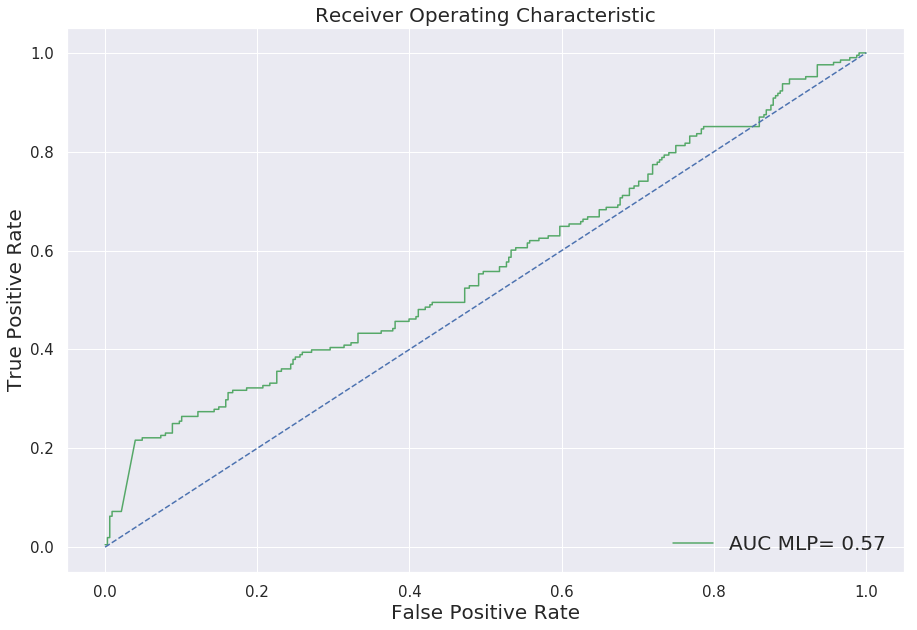

In [45]:
LRs.fit(x_trainl,y_trainl)
y_probl = LRs.predict_proba(x_testl)[:,1]
LRs.score(x_testl, y_pred)
from sklearn.metrics import roc_curve, auc
fprL, tprL, thresholds = roc_curve(y_tests, y_probl)
roc_aucL = auc(fprL, tprL)
roc_aucL

plt.plot(fprL, tprL, color='g',label = 'AUC MLP= %0.2f' % roc_aucL)
plt.title('Receiver Operating Characteristic', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 20)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.xticks(fontsize=15, rotation=None)
plt.yticks(fontsize=15, rotation=None)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate',fontsize = 20)
plt.show()

In [46]:
LRs= LogisticRegression(C = 0.001,penalty='l2')
LRs.fit(x_trainl, y_trainl) 
LRs.score(x_trainl, y_trainl)  
# Predictions on the test dataset
LRpredicted = pd.DataFrame(LRs.predict(x_testl))  
# Probabilities on the test dataset
LRprobs = pd.DataFrame(LRs.predict_proba(x_testl))  
prob0= pd.DataFrame(LRs.predict_proba(x_testl)[:, 0])
prob1 = pd.DataFrame(LRs.predict_proba(x_testl)[:, 1])
logit_mcc = matthews_corrcoef(y_testl, LRpredicted) 
logit_accuracy= metrics.accuracy_score(y_testl, LRpredicted)  
logit_precision = metrics.precision_score(y_testl, LRpredicted, pos_label=1)  
logit_recall = metrics.recall_score(y_testl, LRpredicted, pos_label=1)  
logit_f1 = metrics.f1_score(y_testl, LRpredicted, pos_label=1)
#CROSS VAL
logit_cv_scores = cross_val_score(LRs, x_testl, y_testl, scoring='precision', cv=10)  
logit_cv_mean = np.mean(logit_cv_scores)

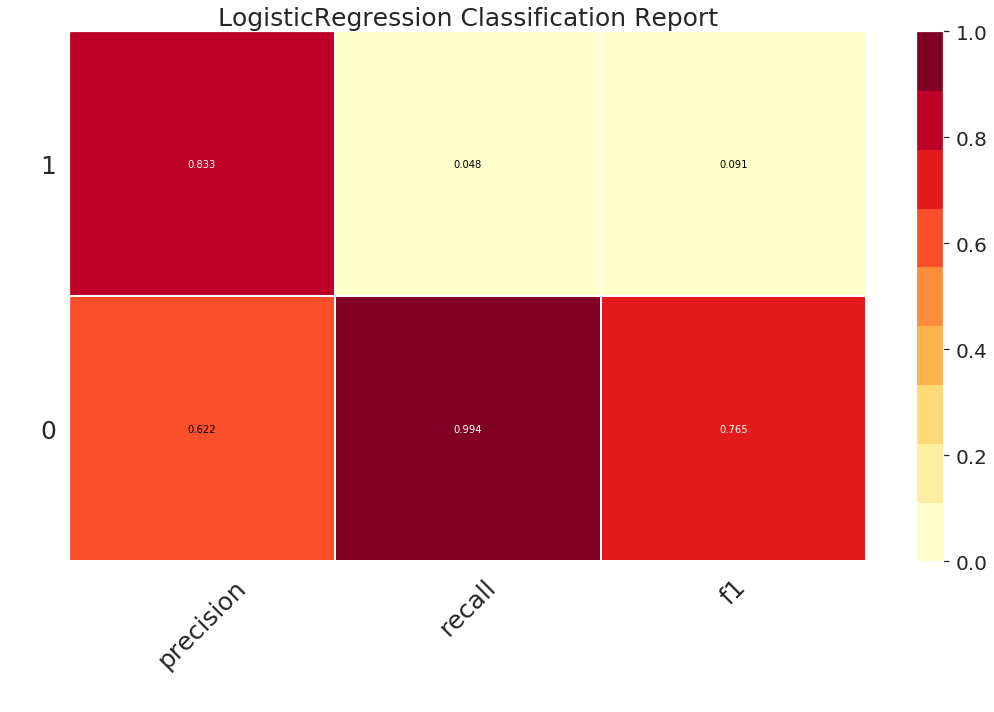

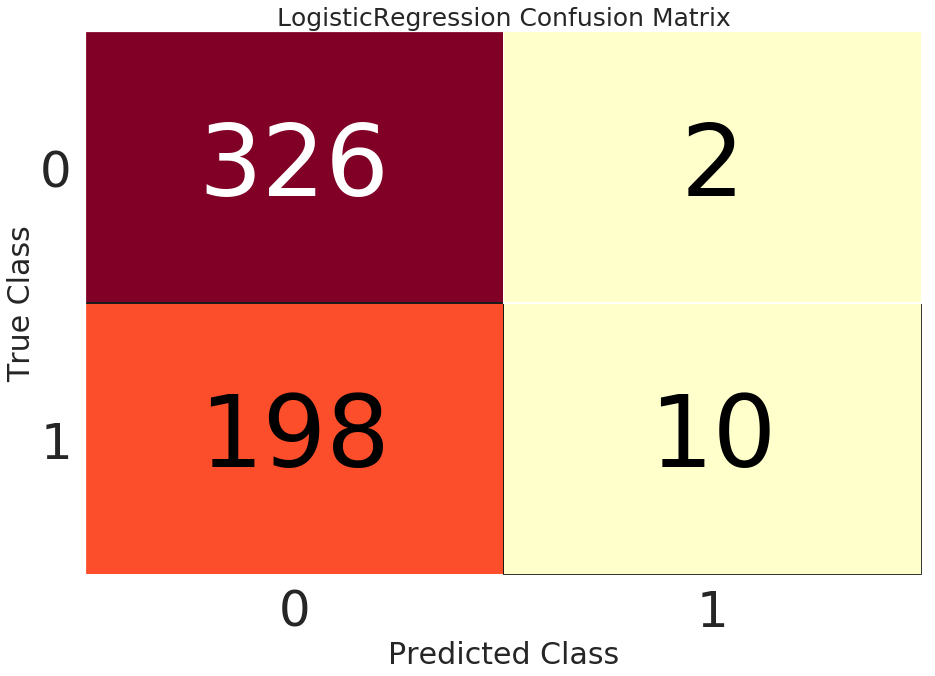

In [47]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
visualizer = ClassificationReport(LRs)
visualizer.fit(x_trainl, y_trainl)
visualizer.score(x_testl, y_testl)
plt.xticks(fontsize=25, rotation=None)
plt.yticks(fontsize=25, rotation=None)
plt.xlabel(r' ', fontsize=30)
plt.ylabel(r' ', fontsize=30)
visualizer.poof()
cm = ConfusionMatrix(LRs, classes=[0,1], fontsize=100)
cm.fit(x_trainl, y_trainl, fontsize=50)
cm.score(x_testl, y_testl, fontsize=50)
plt.xticks(fontsize=50, rotation=None)
plt.yticks(fontsize=50, rotation=None)
plt.xlabel(r' ', fontsize=30)
plt.ylabel(r' ', fontsize=30)
cm.poof()

In [48]:
logit_mcc

0.13827642978260107

## k-nearest neighbors 

K nearest neighbor is a non parametric supervised machine learning that is does no making any assumption about the data. The algorithm learn all the instance in the training data set and in the test data it compares the distances(Euclidean or manhantta)  with the train and the lowest distance is return as the class of the predicted test class. The algorithm uses knowledge of training set to predict the test. low value of k can give high accuracy but also overfit the model. 

## GRID SEARCH

import time
params = {"n_neighbors": np.arange(1, 31, 2),"metric": ["euclidean", "cityblock",'minkowski']}
modelk = KNeighborsClassifier()
grid = GridSearchCV(modelk, params)
start = time.time()
grid.fit(x_train, y_train)

# evaluate the best grid searched model on the testing data
print("[INFO] grid search took {:.2f} seconds".format(time.time() - start))
acc = grid.score(x_train, y_train)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(grid.best_params_))

Score: 0.900914634146
Classification report:
             precision    recall  f1-score   support

          0       0.92      0.93      0.92       328
          1       0.88      0.88      0.88       208

avg / total       0.91      0.91      0.91       536

Confusion Matrix:
[[304  24]
 [ 26 182]]
Accuracy of K-NN classifier on test set: 0.91


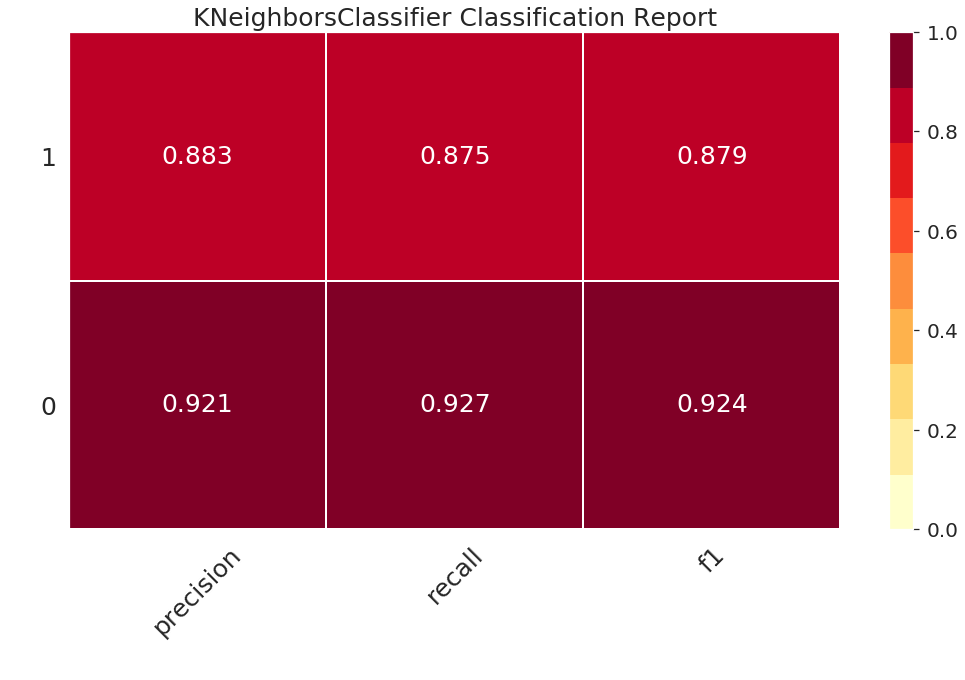

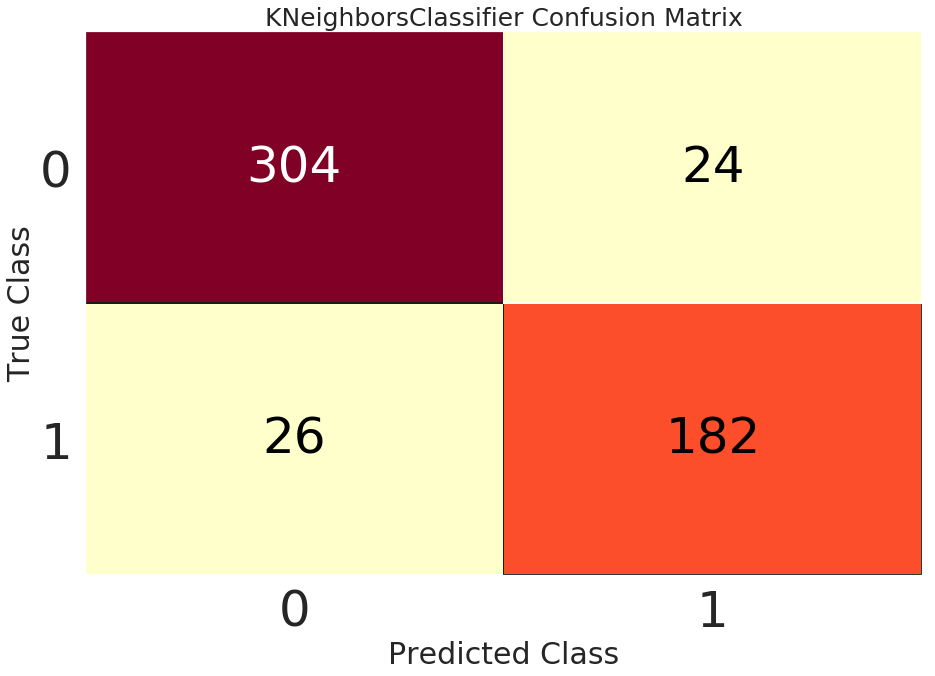

In [49]:
KNN = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
KNN.fit(x_train , y_train)
predictmodel(KNN)
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(KNN.score(x_test, y_test)))

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 25
visualizer = ClassificationReport(KNN)
visualizer.fit(x_train , y_train)
visualizer.score(x_test, y_test)
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25, rotation=None)
plt.xlabel(r' ', fontsize=30)
plt.ylabel(r' ', fontsize=30)
visualizer.poof()
cm = ConfusionMatrix(KNN, classes=[0,1],ax=None,sample_weight=None,
                     percent=False, label_encoder=None,cmap='YlOrRd',fontsize=50)

cm.fit(x_train, y_train, fontsize=50)
cm.score(x_test, y_test, fontsize=50)
plt.xticks(fontsize=50, rotation=None)
plt.yticks(fontsize=50, rotation=None)
plt.xlabel(r' ', fontsize=30)
plt.ylabel(r' ', fontsize=30)
cm.poof()

In [50]:
KNN.fit(x_train , y_train)  
#KNN.score(x_train, y_train)

# Predictions/probs on the test dataset
KNNpredicted = pd.DataFrame(KNN.predict(x_test))  
KNNprobs = pd.DataFrame(KNN.predict_proba(x_test))

# Store metrics
knn_accuracy = metrics.accuracy_score(y_test, KNNpredicted)  
knn_roc_auc = metrics.roc_auc_score(y_test, KNNprobs[1])  
knn_confus_matrix = metrics.confusion_matrix(y_test, KNNpredicted) 
knn_mcc = matthews_corrcoef(y_test, KNNpredicted) 
knn_classification_report = metrics.classification_report(y_test, KNNpredicted)  
knn_precision = metrics.precision_score(y_test, KNNpredicted, pos_label=1)  
knn_recall = metrics.recall_score(y_test, KNNpredicted, pos_label=1)  
knn_f1 = metrics.f1_score(y_test, KNNpredicted, pos_label=1)
# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNN, x_test, y_test, scoring='precision', cv=10)  
knn_cv_mean = np.mean(knn_cv_scores)  


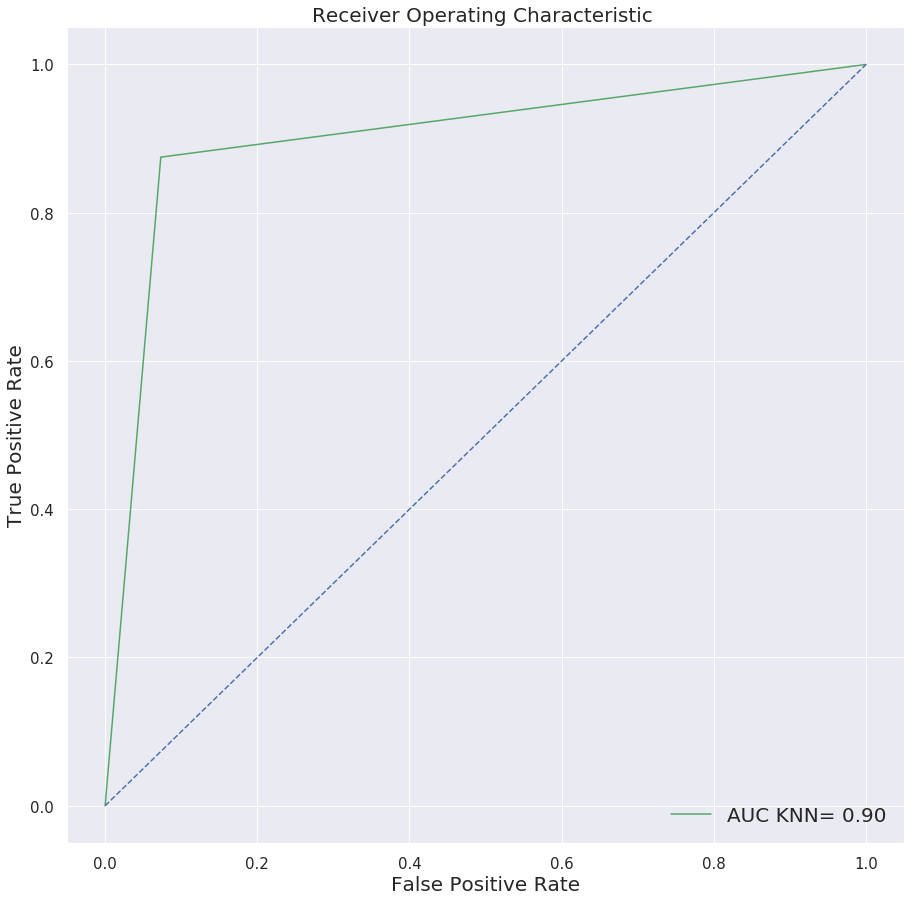

In [51]:

y_probk = KNN.predict_proba(x_test)[:,1]
KNN.score(x_test, y_pred)
from sklearn.metrics import roc_curve, auc
fprK, tprK, thresholdsK = roc_curve(y_test, y_probk)
roc_auck = auc(fprK, tprK)
roc_auck
plt.figure(figsize=(15,15))
plt.plot(fprK, tprK, color='g',label = 'AUC KNN= %0.2f' % roc_auck)
plt.title('Receiver Operating Characteristic ', fontsize = 20)
plt.legend(loc = 'lower right',  fontsize = 20)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.xticks(fontsize=15, rotation=None)
plt.yticks(fontsize=15, rotation=None)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xlabel('False Positive Rate',fontsize = 20)
plt.show()

In [52]:
thresholdsK

array([ 2.,  1.,  0.])

Average precision-recall score KNN: 0.8215657151137516
Average precision-recall score SVM: 0.9528842223249294
Average precision-recall score MLP: 0.961633750988861
Average precision-recall score LR: 0.5160603052821402


Text(0.5,1,'2-class Precision-Recall curve')

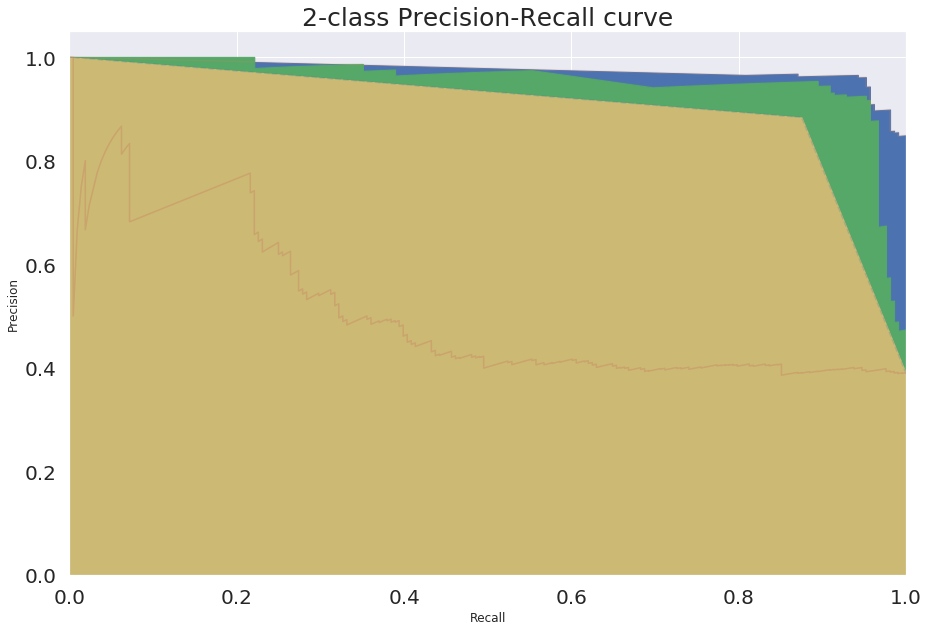

In [53]:
from sklearn.metrics import precision_recall_curve



from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precisionk = average_precision_score(y_test, y_probk)
average_precisions = average_precision_score(y_test, y_pred_probs)
average_precisionm = average_precision_score(y_tests, MLPprob1)
average_precisionl = average_precision_score(y_testl,prob1)
print('Average precision-recall score KNN: {}'.format(average_precisionk))
print('Average precision-recall score SVM: {}'.format(average_precisions))
print('Average precision-recall score MLP: {}'.format(average_precisionm))
print('Average precision-recall score LR: {}'.format(average_precisionl))
precisionK, recallK, _ = precision_recall_curve(y_test, y_probk)

precisionS, recallS, _ = precision_recall_curve(y_test, y_pred_probs)
precisionL, recallL, _ = precision_recall_curve(y_testl,prob1)
precisionM, recallM, _ = precision_recall_curve(y_tests, MLPprob1 )

plt.plot( recallK,precisionK, alpha=0.2, linestyle='--')
plt.plot( recallM, precisionM,alpha=0.2)
plt.plot( recallS ,precisionS,alpha=0.2)
plt.plot( recallL,precisionL, alpha=0.2, color = "r",label = 'AUC LR= %0.2f' % average_precisionl )    
plt.fill_between(recallM, precisionM,color='b')
plt.fill_between(recallL, precisionL,color='r')
plt.fill_between(recallS, precisionS,color='g')
plt.fill_between(recallK, precisionK,color='y')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True);
#plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#          average_precision))

plt.title('2-class Precision-Recall curve')

In [54]:
# Model comparison
models = pd.DataFrame({  
  'Model': ['Logistic Regression', 'Support Vector Classifier', 'K-nearest Neighbor', 'Multi layer Perceptron'],
  'Accuracy' : [logit_accuracy, svm_accuracy, knn_accuracy, MLP_accuracy],
  'Precision': [logit_precision, svm_precision, knn_precision,MLP_precision],
  'recall' : [logit_recall, svm_recall, knn_recall, MLP_recall],
  'F1' : [logit_f1, svm_f1, knn_f1, MLP_f1],
  'cv_precision' :[logit_cv_mean, svm_cv_mean, knn_cv_mean,MLP_cv_mean],
  'Matthews Correlation Coefficient' :[logit_mcc, svm_mcc, knn_mcc,MLP_mcc],
    
'Average precision-recall' : [average_precisionl, average_precisions,average_precisionk, average_precisionm ]
})

#Print table and sort by test precision
models.sort_values(by='Accuracy', ascending=False)
models = models[['Model', 'Accuracy','F1','Precision','cv_precision','recall', 'Matthews Correlation Coefficient', 'Average precision-recall']]
models
#models.to_csv('performance.csv)

,Model,Accuracy,F1,Precision,cv_precision,recall,Matthews Correlation Coefficient,Average precision-recall
0,Logistic Regression,0.626866,0.090909,0.833333,0.543071,0.048077,0.138276,0.516060
1,Support Vector Classifier,0.942164,0.925301,0.927536,0.778346,0.923077,0.878124,0.952884
2,K-nearest Neighbor,0.906716,0.879227,0.883495,0.710488,0.875000,0.803267,0.821566
3,Multi layer Perceptron,0.904851,0.890792,0.803089,0.915468,1.000000,0.823540,0.961634


In [55]:
models['Accuracy']
s = models.loc[:,models.columns.tolist()[0:7]]
df2 = models.set_index("Model", drop = True)

In [56]:
## Cross validation K-fold

In [57]:
num_folds = 5
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed)
result1 = cross_val_score(LRs, X, Y, cv=kfold)
result2 = cross_val_score(KNN, X, Y, cv=kfold)
result3 = cross_val_score(clf, X, Y, cv=kfold)
result4 = cross_val_score(SVM, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (result1.mean(), result1.std()*100.0))
print("Accuracy: %.3f%% (%.3f%%)" % (result2.mean(), result2.std()*100.0))
print("Accuracy: %.3f%% (%.3f%%)" % (result3.mean(), result3.std()*100.0))
print("Accuracy: %.3f%% (%.3f%%)" % (result4.mean(), result4.std()*100.0))

Accuracy: 0.650% (3.024%)
Accuracy: 0.932% (0.340%)
Accuracy: 0.962% (0.726%)
Accuracy: 0.761% (4.093%)


# Compare Algorithms

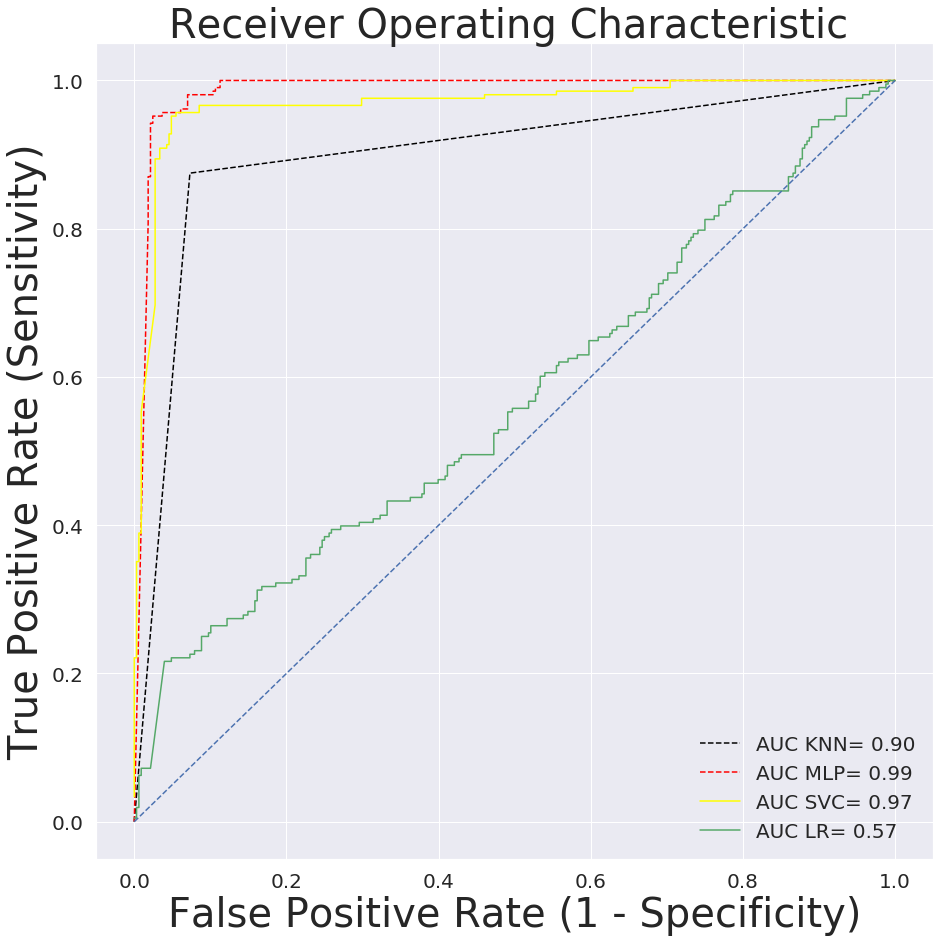

In [58]:
plt.figure(figsize = (15,15))
#plt.plot(fprL, tprL, color='g',label = 'AUC LR= %0.2f' % roc_aucL)
plt.plot(fprK, tprK, color='black',linestyle='--',label = 'AUC KNN= %0.2f' % roc_auck)
plt.plot(false_positive_rate,true_positive_rate,linestyle='--',color='red',label = 'AUC MLP= %0.2f' % roc_auc)
plt.plot(fpr, tpr, color = 'yellow', linestyle='-',label = 'AUC SVC= %0.2f' % Roc_Auc)
plt.plot(fprL, tprL, color='g',label = 'AUC LR= %0.2f' % roc_aucL)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'lower right',fontsize = 20)
plt.rcParams['font.size'] = 12
plt.yticks(fontsize=20, rotation=None)
plt.xticks(fontsize=20, rotation=None)
plt.title('Receiver Operating Characteristic ' , fontsize = 40)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 40)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 40)
plt.plot([0, 1], [0, 1],linestyle='--',label = 'random guess  %0.2f' )
plt.axis('tight')
plt.grid(True);
plt.show()

Area Under SVM: 0.96
Area Under MLP: 0.98
Area Under KNN: 0.90
Area Under LR: 0.51


(-0.050000000000000003, 1.05, -0.050000000000000003, 1.05)

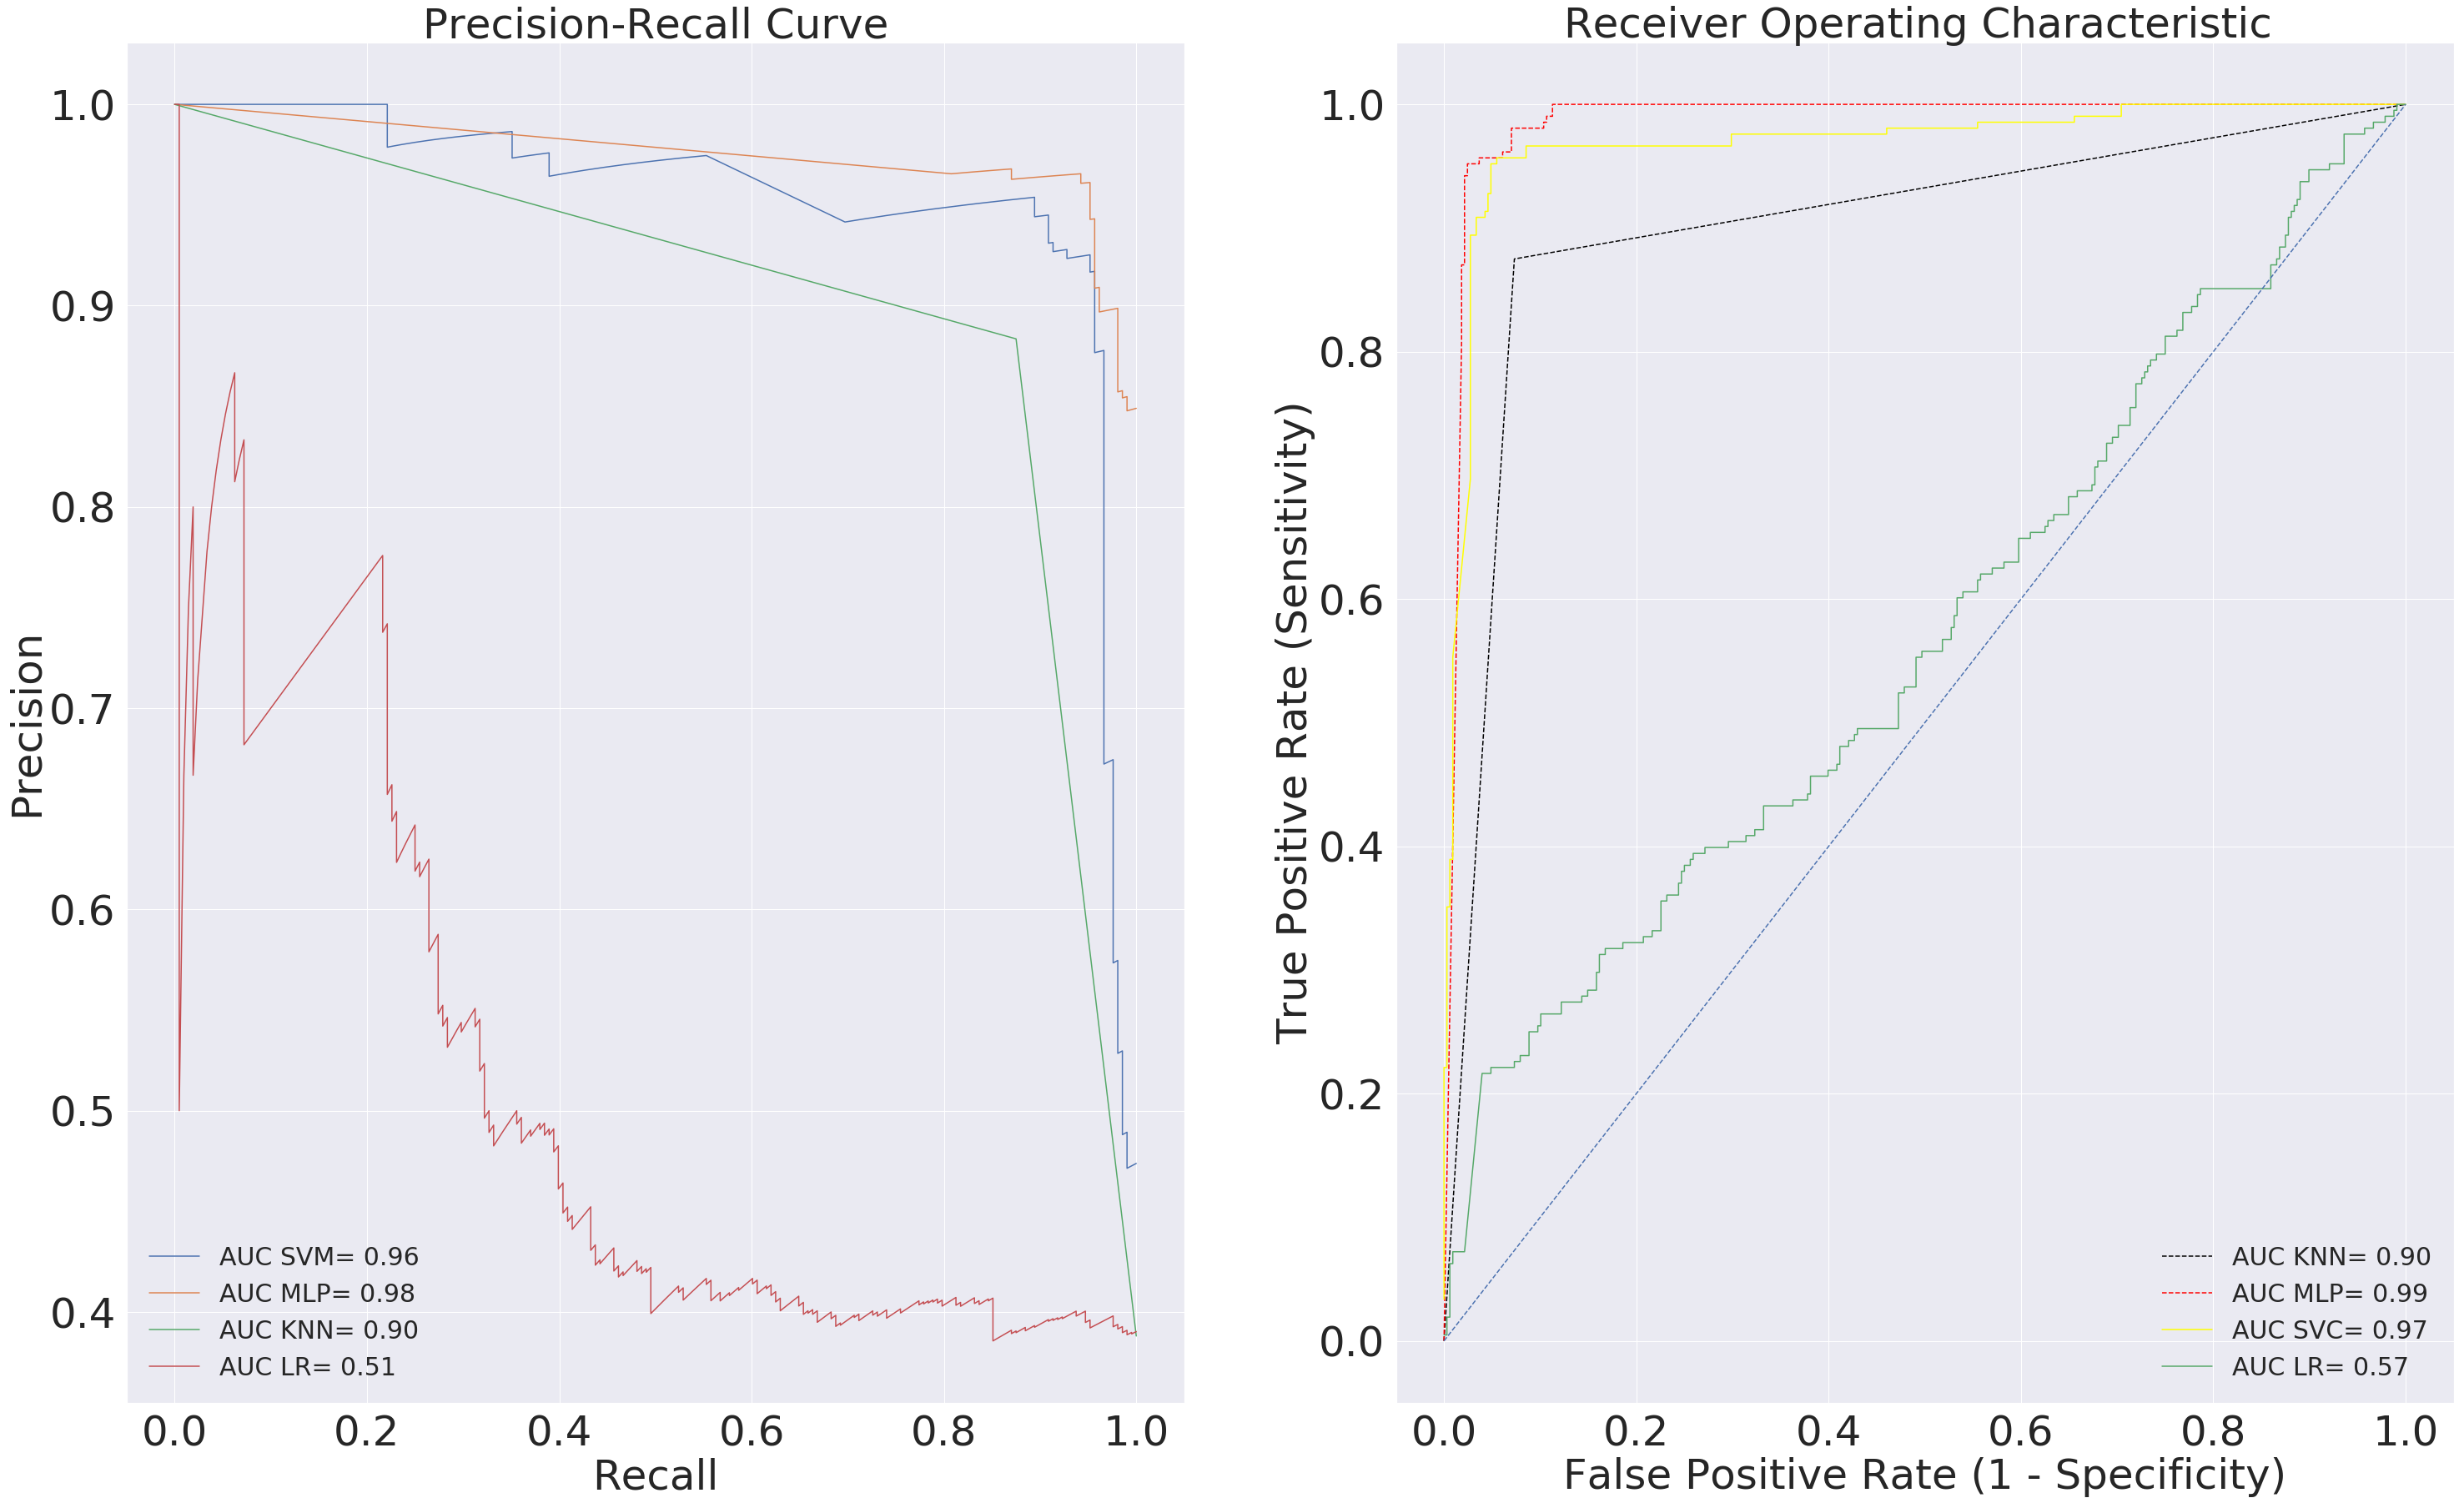

In [59]:
import pylab as pl
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


# Run classifier
#classifier = svm.SVC(kernel='linear', probability=True, scale_C=True)
#probas_ = classifier.fit(X[:half], y[:half]).predict_proba(X[half:])

# Compute Precision-Recall and plot curve
precisions, recalls, thresholdss = precision_recall_curve(y_test, SMprobs[1])
areas = auc(recalls, precisions)

precisionm, recallm, thresholdsm = precision_recall_curve(y_tests, y_prob1)
aream = auc(recallm, precisionm)

precisionk, recallk, thresholdsk = precision_recall_curve(y_test, y_probk)
areak = auc(recallk, precisionk)

precisionl, recalll, thresholdsl = precision_recall_curve(y_tests, y_probl)

areal = auc(recalll, precisionl)

fig = plt.figure(figsize=(50,30))

ax1 = fig.add_subplot(121)



print( "Area Under SVM: %0.2f" % areas)
print( "Area Under MLP: %0.2f" % aream)
print( "Area Under KNN: %0.2f" % areak)
print( "Area Under LR: %0.2f" % areal)

#pl.clf()
#plt.figure(figsize=(15,15))
#plt.rcParams['font.size'] = 12
plt.yticks(fontsize=50, rotation=None)
plt.xticks(fontsize=50, rotation=None)
plt.plot(recalls, precisions, label = 'AUC SVM= %0.2f' %  areas)
plt.plot(recallm, precisionm, label = 'AUC MLP= %0.2f' % aream)
plt.plot(recallk, precisionk, label = 'AUC KNN= %0.2f' % areak)
plt.plot(recalll, precisionl, label = 'AUC LR= %0.2f' % areal)
plt.xlabel('Recall', fontsize = 50)
plt.ylabel('Precision', fontsize = 50)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve', fontsize =50)
plt.legend(loc="lower left",fontsize =30)
plt.axis('tight')
ax1 = fig.add_subplot(122)
#plt.plot(fprL, tprL, color='g',label = 'AUC LR= %0.2f' % roc_aucL)
plt.plot(fprK, tprK, color='black',linestyle='--',label = 'AUC KNN= %0.2f' % roc_auck)
plt.plot(false_positive_rate,true_positive_rate,linestyle='--',color='red',label = 'AUC MLP= %0.2f' % roc_auc)
plt.plot(fpr, tpr, color = 'yellow', linestyle='-',label = 'AUC SVC= %0.2f' % Roc_Auc)
plt.plot(fprL, tprL, color='g',label = 'AUC LR= %0.2f' % roc_aucL)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'lower right',fontsize = 30)

#plt.rcParams['font.size'] = 20
plt.yticks(fontsize=50, rotation=None)
plt.xticks(fontsize=50, rotation=None)
plt.title('Receiver Operating Characteristic ' , fontsize = 50)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 50)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 50)
plt.plot([0, 1], [0, 1],linestyle='--',label = 'random guess  %0.2f' )
plt.axis('tight')
#plt.grid(True)
#plt.show()

In [60]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
#    fig = plt.figure(figsize=(40,20))
 #   ax1 = fig.add_subplot(121)

#     ax1 = fig.add_subplot()
#     plt.subplot(2, 2, 1)
#     plt.subplot(2, 2, 2)
#     plt.subplot(2, 2, 3)
#     plt.subplot(2, 2, 4)
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples",fontsize=50 )
    plt.ylabel("Score",fontsize=50)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="green",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="darkblue",
             label="Cross-validation score")
    plt.yticks(fontsize=50, rotation=None)
    plt.xticks(fontsize=50, rotation=None)

    plt.legend(loc="best", fontsize=40)
    return plt




# estimatorl = LRs
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# ax1 = fig.add_subplot(212)

# plot_learning_curve(estimatorl, x, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
# estimatorK = KNN
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# ax1 = fig.add_subplot(211)
# plot_learning_curve(estimatorK, x, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [61]:
xx = data.loc[:,data.columns.tolist()[0:4]]

<module 'matplotlib.pyplot' from '/home/aimsadmin/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

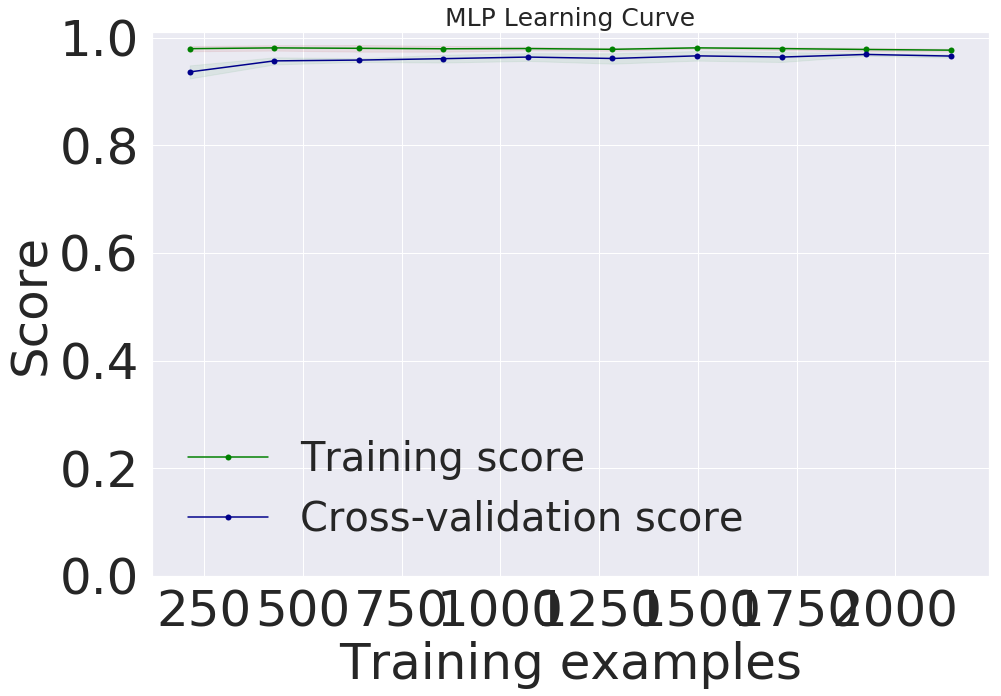

In [62]:

estimator = clf
#ax1 = fig.add_subplot(221)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plt.rcParams['axes.titlesize'] = 25
#title1 = "MLP Learning Curve"
plt.grid()
plt.title("MLP Learning Curve")
plot_learning_curve(estimator, X, Y, ylim=(0, 1.01), cv=cv, n_jobs=4)


<module 'matplotlib.pyplot' from '/home/aimsadmin/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

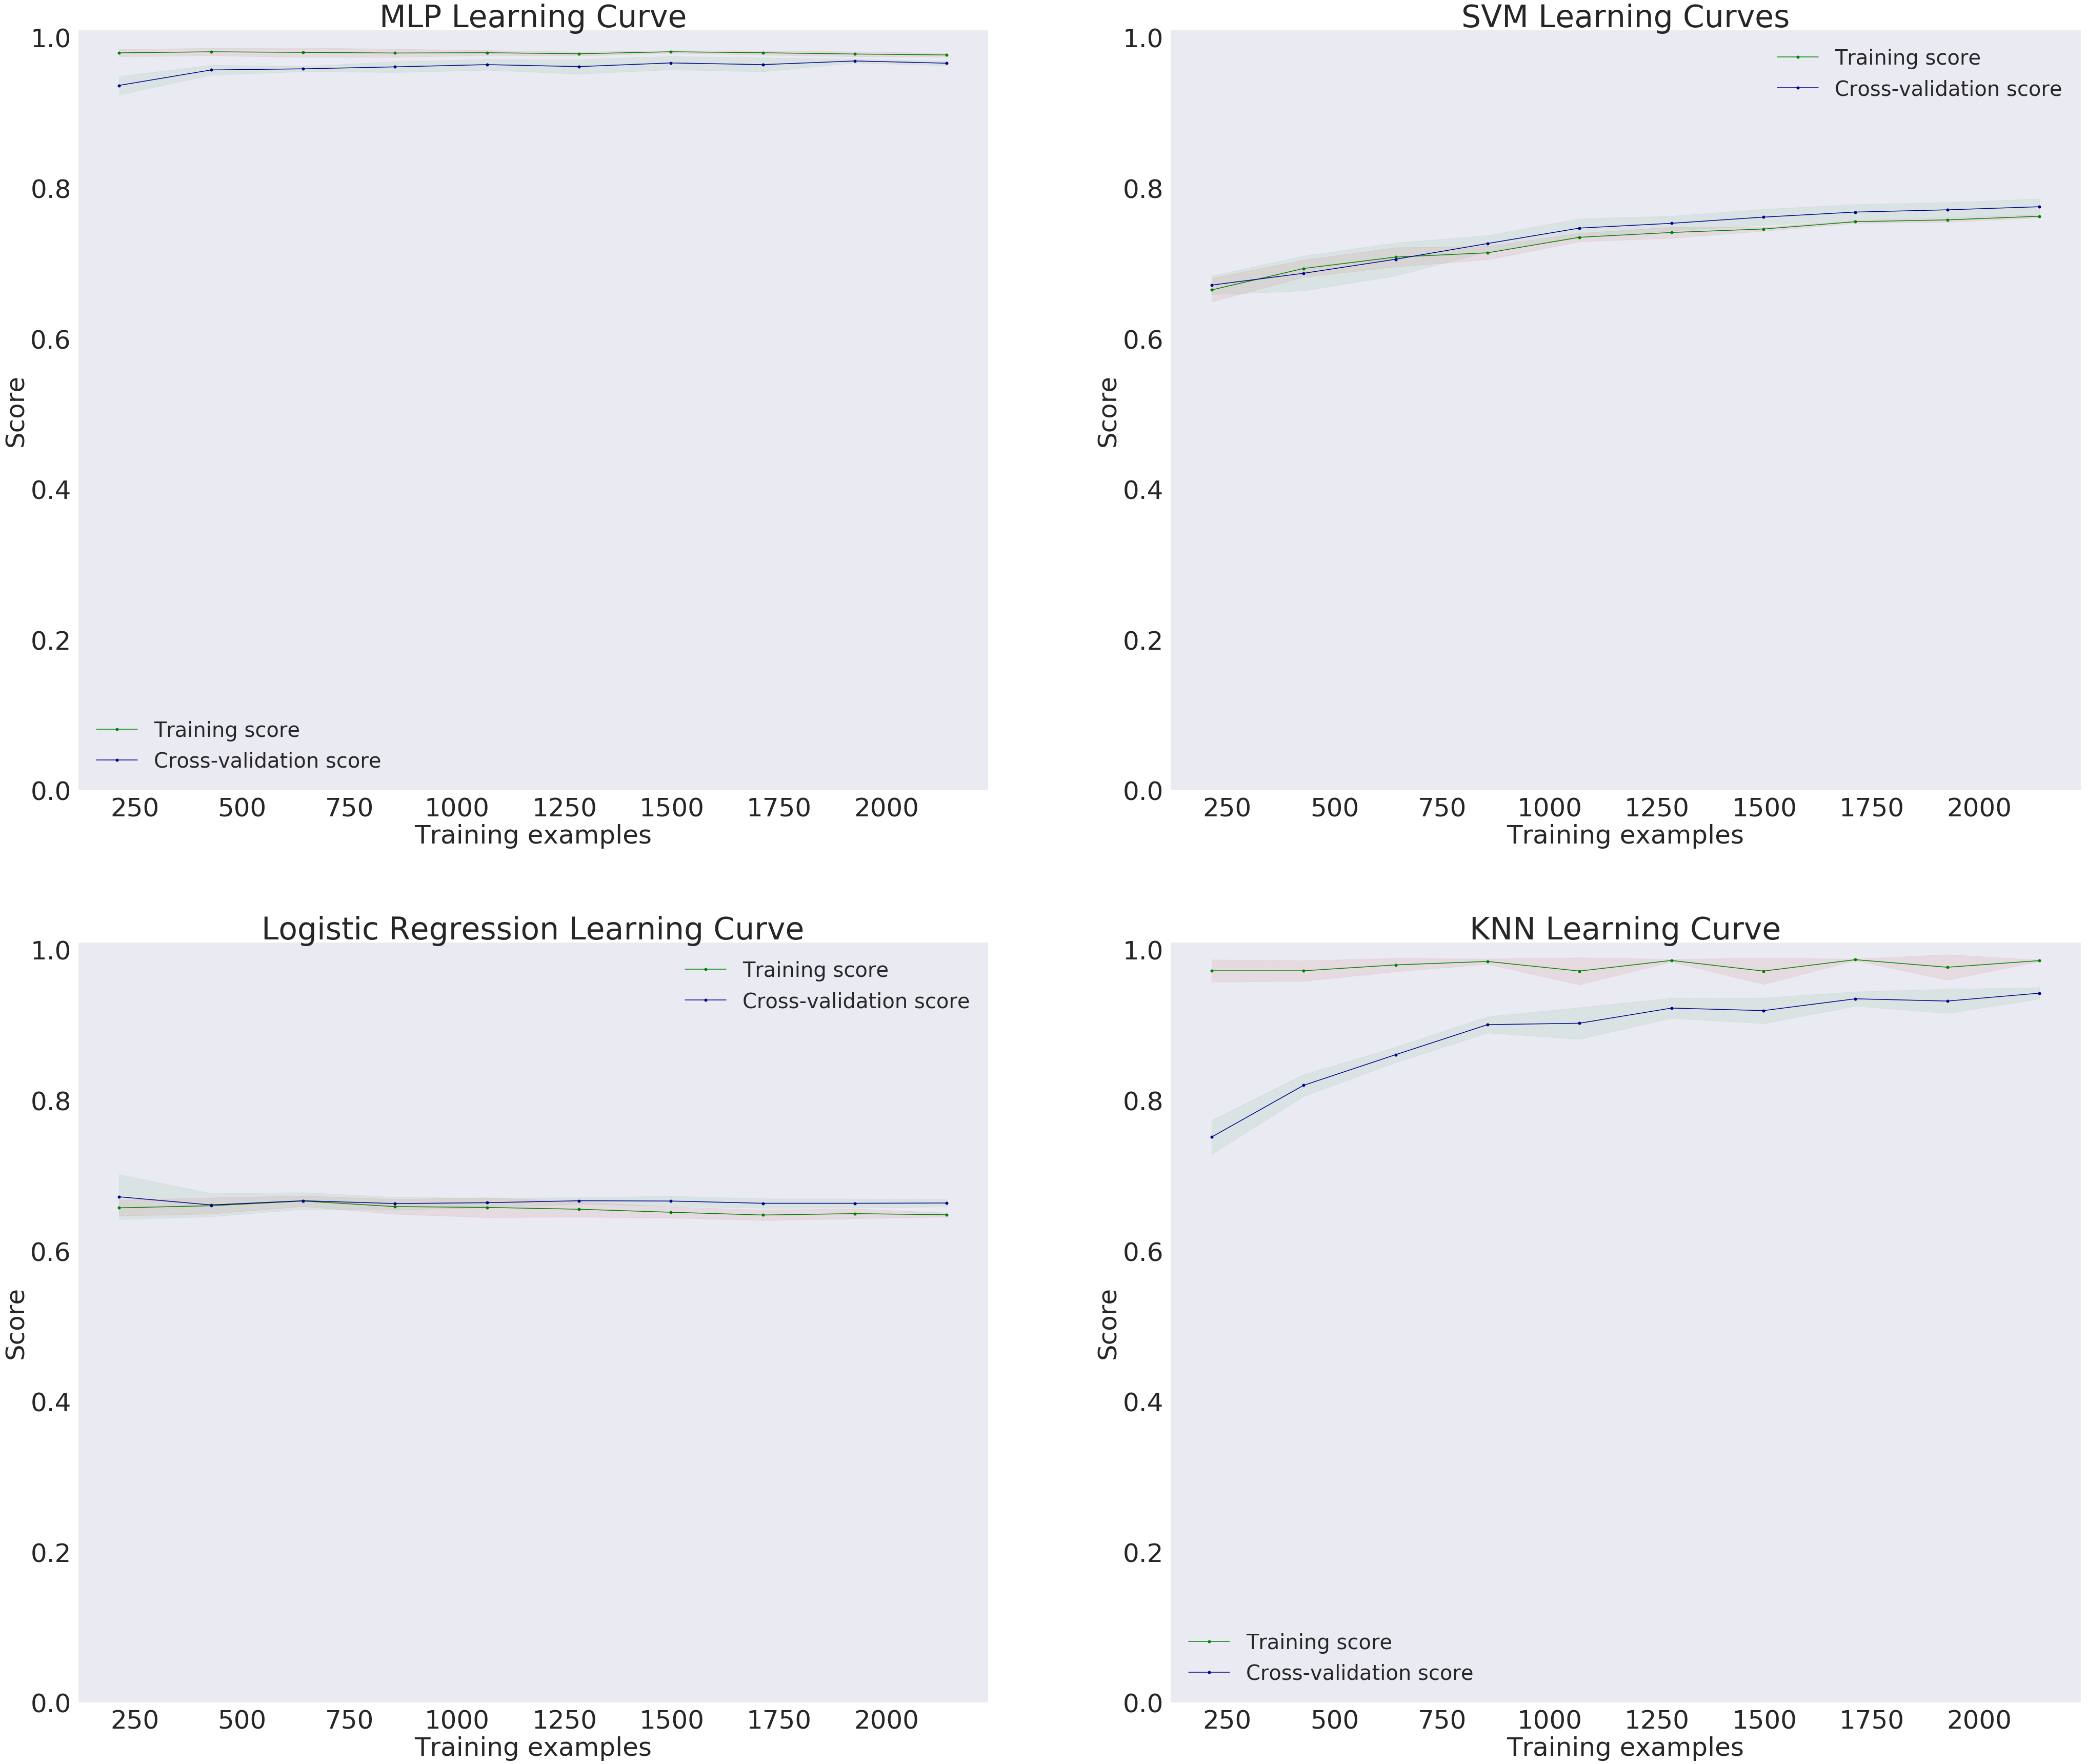

In [63]:
fig = plt.figure(figsize=(70,60))

estimator = clf
ax1 = fig.add_subplot(221)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plt.rcParams['axes.titlesize'] = 60
title1 = "MLP Learning Curve"
plt.grid(True);
plt.title("MLP Learning Curve")
plot_learning_curve(estimator, X, Y, ylim=(0, 1.01), cv=cv, n_jobs=4)



ax1 = fig.add_subplot(222)
estimatorS = SVM
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plt.rcParams['axes.titlesize'] = 60
#title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
plt.grid(True);
plt.title("SVM Learning Curves")
plot_learning_curve(estimatorS, X, Y, ylim=(0, 1.01), cv=cv, n_jobs=4)



ax1 = fig.add_subplot(223)
estimatorl = LRs
plt.rcParams['axes.titlesize'] = 60
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plt.grid(True);
plt.title("Logistic Regression Learning Curve")
plot_learning_curve(estimatorl, X, Y, ylim=(0, 1.01), cv=cv, n_jobs=4)






ax1 = fig.add_subplot(224)
estimatorK = KNN
plt.rcParams['axes.titlesize'] = 60
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plt.title("KNN Learning Curve")
plt.grid(True);
plot_learning_curve(estimatorK, X,Y, ylim=(0, 1.01), cv=cv, n_jobs=4)

In [64]:
# import scikitplot as skplt
# pca = PCA(random_state=1)
# pca.fit(DATA)
# skplt.decomposition.plot_pca_component_variance(pca)
# plt.show()

## ENSEMBLE LEARNING with standardize x variables


The max voting method is generally used for classification problems.In this technique, multiple models are used to make predictions for each data point. The predictions by each model are considered as a ‘vote’. The predictions which we get from the majority of the models are used as the final prediction.

## MAX VOTING

In [65]:
# model1 = KNeighborsClassifier()
# model2 = MLPClassifier()
# model3 = LogisticRegression()
# model4 = SVC(probability = True)
model1 = KNN
model2 = clf
model3 = LRs
model4 = SVM
# x_trains- standardized samaple

model1.fit(x_trains,y_trains)
model2.fit(x_trains,y_trains)
model3.fit(x_trains,y_trains)
model4.fit(x_trains,y_trains)

from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[('KNN', model1), ('MLP', model2), ('LR', model3), ('SVM', model4)], voting='soft')
model.fit(x_trains,y_trains)
score = model.score(x_tests,y_tests)
model.score(x_tests,y_tests)

0.91231343283582089

In [66]:
## ENSEMBLE LEARNING with standardize x variables and default hyperparameter

In [67]:
model1 = KNeighborsClassifier()
model2 = MLPClassifier()
model3 = LogisticRegression()
model4 = SVC(probability=True)
# model1 = KNN
# model2 = clf
# model3 = LRs
# model4 = SVM
# x_trains- standardized samaple

model1.fit(x_trains,y_trains)
model2.fit(x_trains,y_trains)
model3.fit(x_trains,y_trains)
model4.fit(x_trains,y_trains)

from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[('KNN', model1), ('MLP', model2), ('LR', model3), ('SVM', model4)], voting='soft')
model.fit(x_trains,y_trains)
score = model.score(x_tests,y_tests)
model.score(x_tests,y_tests)

0.92164179104477617

## Averaging

In this method, we take an average of predictions from all the models and use it to make the final prediction. Averaging can be used for making predictions in regression problems or while calculating probabilities for classification problems.

In [68]:

model1.fit(x_trains,y_trains)
model2.fit(x_trains,y_trains)
model3.fit(x_trains,y_trains)
model4.fit(x_trains,y_trains)


pred1=model1.predict_proba(x_tests)
pred2=model2.predict_proba(x_tests)
pred3=model3.predict_proba(x_tests)
pred4=model4.predict_proba(x_tests)
finalpred=(pred1+pred2+pred3)/3
finalpred

array([[ 0.873,  0.127],
       [ 0.411,  0.589],
       [ 0.867,  0.133],
       ..., 
       [ 0.24 ,  0.76 ],
       [ 0.851,  0.149],
       [ 0.331,  0.669]])

## K-FOLD CROSS VALIDATION  

In [69]:
kfold = model_selection.KFold(n_splits=5, random_state=seed)

model1 = KNN
model2 = clf
model3 = LRs
model4 = SVM
estimators = []

estimators.append(('knn', model1))

estimators.append(('mlp', model2))

estimators.append(('lr', model3))

estimators.append(('svm', model4))
# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft')
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

0.950297112568


## K-FOLD CROSS VALIDATION withdefaul hyperparameters

In [70]:
kfold = model_selection.KFold(n_splits=5, random_state=seed)

model1 = KNeighborsClassifier()
model2 = MLPClassifier()
model3 = LogisticRegression()
model4 = SVC( probability=True)

estimators = []

estimators.append(('knn', model1))

estimators.append(('mlp', model2))

estimators.append(('lr', model3))

estimators.append(('svm', model4))
# create the ensemble model
ensemble = VotingClassifier(estimators,  voting='soft')
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

0.907318314967
